Copyright © 2023 Liping LI. All rights reserved.
Part 1 : Load each image and do cortex normalization and Min-Max normalization
Part 2 : Plot histogram of original image, cortex_norm image, cortex_norm & Min-Max_norm image(one slice of one patient)
Part 3: Check each slice and the coresponding mask
Part 4: Align the image and the mask, only work when resampling is needed
Part 5: Feature extraction: two versions of extraction.
Part 6: Plot histogram for the original, cortext norm, cortext-MinMax norm of all 17 patinets at each timepoint                     respectively
Part 7: plot images with masks for the original, cortext norm, cortext-MinMax norm of two groups(three cases for each) at           each timepoint respectively

In [ ]:
#Part 1 : load each image and do cortex normalization and Min-Max normalization
import os
import numpy as np
import nibabel as nib
import nrrd
from radiomics import featureextractor, getFeatureClasses
import SimpleITK as sitk
import six  # Ensure you have the 'six' library installed for Python 3 compatibility
#import seaborn as sns
from scipy.ndimage import zoom

In [ ]:
#####you shoud only change the path and folder as you need in the cell below

In [ ]:
# Directory containing MRI images and masks
#corrected dataset
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/'

original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations'
cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
cortext_MinMax_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'

# Get a list of all subdirectories in the main directory
subdirectories = [f for f in os.listdir(dir_root) if os.path.isdir(os.path.join(dir_root, f))]
print('folder_names shape: ', len(subdirectories))
print('folder_names: ', subdirectories)

In [ ]:
# Loop through each subdirectory
for folder_name in subdirectories:
    time_point = '/timepoint0/'
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('_Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            ###mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
            #mri_path = data_dir + '/28_ax_vibe_arterial_sub.nii'
            ###cortex_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '_Cortex.seg.nrrd'))
            
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
            print('mri_path: ', mri_path)
            
            # If no .nii.gz file is found or it is not valid, try to load a .nii file
            if filename.replace('_Mass.seg.nrrd', '.nii.gz') in os.listdir(data_dir):
                print(True)
            else:
                mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii')) 
                print(f"The NIfTI file '{mri_path}' is valid.")

            cortex_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '_Cortex.seg.nrrd'))

            print('mask_path:', mask_path)
            print('mri_path:', mri_path)
            print('cortex_path:', cortex_path)

            # Load MRI image and mask

            nifti_image = nib.load(mri_path)
            original_img_path = os.path.join(original_output_path, folder_name + '.nii.gz')
            nib.save(nifti_image, original_img_path)
            #mri_image = nib.load(mri_path).get_fdata()
            print(nifti_image.header)

            # Access the image data
            mri_image = nifti_image.get_fdata()


            # Access the image affine transformation matrix
            affine_matrix = nifti_image.affine

            # Get the image origin from the affine matrix
            image_origin = affine_matrix[:3, 3]

            # Get the image spacing (voxel size) from the affine matrix
            image_spacing = np.sqrt(np.sum(affine_matrix[:3, :3] ** 2, axis=0))


            ##mask_data, mask_header = nrrd.read(mask_path)
            mask_data = sitk.ReadImage(mask_path)

            cortex_data, cortex_header = nrrd.read(cortex_path)
            print('cortex_data', cortex_data)
            # Calculate the mean value in the cortex region
            #mean_Cortex :  316.11347517730496
            mean_Cortex = mri_image[cortex_data > 0].mean()
            print("mean_Cortex : ", mean_Cortex)

            # Scale the volume data with mean_Cortex
            mri_norm = mri_image / mean_Cortex
            print('mri_norm: ', mri_norm.mean)
            print('mri_norm: ', mri_norm.size) #mri_image_norm size:  (288, 232, 104)

            #convert the cortex normed array into image and save as nifti
            #please drop this line if no need to save the image
            norm_cortex_image = nib.Nifti1Image(mri_norm, affine_matrix, nifti_image.header)
            norm_cortex_path = os.path.join(cortext_norm_output_path, folder_name + '_Rightcortex_norm.nii.gz')
            nib.save(norm_cortex_image, norm_cortex_path)

            #normalize the data to [0,1]
            # Get the min and max intensities
            normalzed_img  = (mri_norm - np.min(mri_norm)) / (np.max(mri_norm) - np.min(mri_norm))  

            ###convert th eformat as uint8
            ###mri_norm_uint8 = mri_norm.astype(np.uint8)

            # Create a new NIfTI image with the normalized data
            #####normalized_nifti_image = nib.Nifti1Image(mri_norm_uint8, affine_matrix, nifti_image.header)
            #normalized_nifti_image.header = nifti_image.header
            normalized_nifti_image = nib.Nifti1Image(normalzed_img, affine_matrix, nifti_image.header)

            #normalized_nifti_image.astype = 'uint8'

            normalized_mri_path = os.path.join(cortext_MinMax_norm_output_path, folder_name + '_Right.nii.gz')
            normalized_mri_path = normalized_mri_path.replace('\\', '/') 
            print('normalized_mri_path', normalized_mri_path)

            # Save normalized MRI image
            #nifti_mri_norm = nib.Nifti1Image(mri_norm, affine=None)
            nib.save(normalized_nifti_image, normalized_mri_path)

            mri_image_norm = sitk.ReadImage(normalized_mri_path)
            print('mri_image_norm size: ', mri_image_norm.GetSize())
            print('mri_image_norm direction: ', mri_image_norm.GetDirection())
            print('mri_image_norm spacing: ', mri_image_norm.GetSpacing())

            print('mask_data size: ', mask_data.GetSize())
            print('mask_data direction:: ', mask_data.GetDirection())
            print('mask_data spacing: ', mask_data.GetSpacing())
            #mri_image_norm Size:  (288, 232, 88)
            #mask_data:  (288, 232, 88)

            # Save normalized mask
            ##normalized_mask_path = os.path.join(data_dir, f'normalized_{filename.replace(".nii.gz", ".nrrd")}')
            ##pynrrd.write(normalized_mask_path, normalized_mask, options=mask_header)

In [8]:
import os
import numpy as np
import nibabel as nib
import nrrd
from radiomics import featureextractor, getFeatureClasses
import SimpleITK as sitk
import six 
#import seaborn as sns
from scipy.ndimage import zoom

# Directory containing MRI images and masks
#corrected dataset
#aorta normalization
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/'

original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
aorta_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
#cortext_MinMax_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'

# Get a list of all subdirectories in the main directory
subdirectories = [f for f in os.listdir(dir_root) if os.path.isdir(os.path.join(dir_root, f))]
print('folder_names shape: ', len(subdirectories))
print('folder_names: ', subdirectories)

# Loop through each subdirectory
for folder_name in subdirectories:
    time_point = '/timepoint1/'
    folder_path = folder_name + time_point
    data_dir = dir_root + time_point
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('_Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            ###mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
            #mri_path = data_dir + '/28_ax_vibe_arterial_sub.nii'
            ###cortex_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '_Cortex.seg.nrrd'))
            
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
            print('mri_path: ', mri_path)
            
            # If no .nii.gz file is found or it is not valid, try to load a .nii file
            if filename.replace('_Mass.seg.nrrd', '.nii.gz') in os.listdir(data_dir):
                print(True)
            else:
                mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii')) 
                print(f"The NIfTI file '{mri_path}' is valid.")

            cortex_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '_resample_Aorta.seg.nrrd'))

            print('mask_path:', mask_path)
            print('mri_path:', mri_path)
            print('cortex_path:', cortex_path)

            

            # Load MRI image and mask

            nifti_image = nib.load(mri_path)
            original_img_path = os.path.join(original_output_path, folder_name + '.nii.gz')
            nib.save(nifti_image, original_img_path)
            #mri_image = nib.load(mri_path).get_fdata()
            print(nifti_image.header)

            # Access the image data
            mri_image = nifti_image.get_fdata()


            # Access the image affine transformation matrix
            affine_matrix = nifti_image.affine

            # Get the image origin from the affine matrix
            image_origin = affine_matrix[:3, 3]

            # Get the image spacing (voxel size) from the affine matrix
            image_spacing = np.sqrt(np.sum(affine_matrix[:3, :3] ** 2, axis=0))


            ##mask_data, mask_header = nrrd.read(mask_path)
            mask_data = sitk.ReadImage(mask_path)

            # mask_data_array = sitk.GetArrayFromImage(mask_data)
            # # nifti_image_array = sitk.GetArrayFromImage(nifti_image)

            # # print('image shape:', nifti_image_array.shape)
            # print('mask shape:', mask_data_array.shape)

            # mri_image_from_array = sitk.GetImageFromArray(mri_image)

            # image_spacing = mri_image_from_array.GetSpacing()
            # image_origin = mri_image_from_array.GetOrigin()
            # image_direction = mri_image_from_array.GetDirection()

            # # Create a resampling object
            # resampler = sitk.ResampleImageFilter()
            # resampler.SetOutputSpacing(image_spacing)
            # resampler.SetOutputOrigin(image_origin)
            # resampler.SetOutputDirection(image_direction)
            # resampler.SetSize(mri_image_from_array.GetSize())

            # # Resample the mask
            # aligned_mask = resampler.Execute(mask_data)
            # aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)
            # mask = aligned_mask
            # maskName = aligned_mask_array

            # # Get unique values in the msk array
            # unique_values = np.unique(aligned_mask_array)

            # # Print the unique values
            # print("Unique values in the aligned_mask:")
            # print(unique_values)

            cortex_data, cortex_header = nrrd.read(cortex_path)
            print('cortex_data', cortex_data)

            print('cortex_data shape:', cortex_data.shape)
            print('mri_image shape:', mri_image.shape)

            # Calculate the mean value in the cortex region
            #mean_Cortex :  316.11347517730496
            mean_Cortex = mri_image[cortex_data > 0].mean()
            print("mean_Cortex : ", mean_Cortex)

            # Scale the volume data with mean_Cortex
            mri_norm = mri_image / mean_Cortex
            print('mri_norm: ', mri_norm.mean)
            print('mri_norm: ', mri_norm.size) #mri_image_norm size:  (288, 232, 104)

            #convert the cortex normed array into image and save as nifti
            #please drop this line if no need to save the image
            norm_cortex_image = nib.Nifti1Image(mri_norm, affine_matrix, nifti_image.header)
            norm_cortex_path = os.path.join(aorta_output_path, folder_name + '.nii.gz')
            nib.save(norm_cortex_image, norm_cortex_path)

            #normalize the data to [0,1]
            # Get the min and max intensities
            normalzed_img  = (mri_norm - np.min(mri_norm)) / (np.max(mri_norm) - np.min(mri_norm))  

            ###convert th eformat as uint8
            ###mri_norm_uint8 = mri_norm.astype(np.uint8)

            # Create a new NIfTI image with the normalized data
            #####normalized_nifti_image = nib.Nifti1Image(mri_norm_uint8, affine_matrix, nifti_image.header)
            #normalized_nifti_image.header = nifti_image.header
            normalized_nifti_image = nib.Nifti1Image(normalzed_img, affine_matrix, nifti_image.header)

            #normalized_nifti_image.astype = 'uint8'

            normalized_mri_path = os.path.join(aorta_output_path, folder_name + '_normalized.nii.gz')
            normalized_mri_path = normalized_mri_path.replace('\\', '/') 
            print('normalized_mri_path', normalized_mri_path)

            # Save normalized MRI image
            #nifti_mri_norm = nib.Nifti1Image(mri_norm, affine=None)
            nib.save(normalized_nifti_image, normalized_mri_path)

            mri_image_norm = sitk.ReadImage(normalized_mri_path)
            print('mri_image_norm size: ', mri_image_norm.GetSize())
            print('mri_image_norm direction: ', mri_image_norm.GetDirection())
            print('mri_image_norm spacing: ', mri_image_norm.GetSpacing())

            print('mask_data size: ', mask_data.GetSize())
            print('mask_data direction:: ', mask_data.GetDirection())
            print('mask_data spacing: ', mask_data.GetSpacing())
            #mri_image_norm Size:  (288, 232, 88)
            #mask_data:  (288, 232, 88)

            # Save normalized mask
            ##normalized_mask_path = os.path.join(data_dir, f'normalized_{filename.replace(".nii.gz", ".nrrd")}')
            ##pynrrd.write(normalized_mask_path, normalized_mask, options=mask_header)

folder_names shape:  4
folder_names:  ['timepoint3', 'timepoint2', 'timepoint0', 'timepoint1']
mri_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335//timepoint1/27_ax_vibe_arterial.nii.gz
True
mask_path: /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335//timepoint1/27_ax_vibe_arterial_Mass.seg.nrrd
mri_path: /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335//timepoint1/27_ax_vibe_arterial.nii.gz
cortex_path: /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335//timepoint1/27_ax_vibe_arterial_resample_Aorta.seg.nrrd
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 288 240 112   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16

In [ ]:
#Part 2 : plot histogram of original image, cortex_norm image, cortex_norm & Min-Max_norm image

In [ ]:
#abnormal nii_file:  42256342, 49121664, 84867994
#normal: 12034721, 29856335, 55990956
# original_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/original image/'
# cortext_norm_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext norm image/'
# cortext_MinMax_norm_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext MinMax norm image/'

time_point = '/timepoint0/'
folder_name = '55990956'
folder_path = folder_name + time_point
data_dir = dir_root + folder_path

In [ ]:
# Load the coressponding kidney mask

for filename in os.listdir(data_dir):
    if filename.endswith('_Kidney.seg.nrrd'):
        kidney_mask_path = os.path.join(data_dir, filename)
        kidney_mask = sitk.ReadImage(kidney_mask_path)

# Select the slice number you want to display
slice_number = 38  # Change this to the desired slice number


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Replace 'ct_scan_data' with your actual CT scan data
# Ensure that 'ct_scan_data' is a 2D NumPy array representing the CT image.
# You might need to load and preprocess the data depending on the format.
# For DICOM files, you can use pydicom, and for other formats, you may need different libraries.

##original image: mri_image; cortex_norm: mri_norm; cortex_norm & Min-Max_norm: normalzed_img
mri_path = os.path.join(original_output_path, folder_name + '.nii.gz')

original_img = sitk.ReadImage(mri_path)
original_array = sitk.GetArrayFromImage(original_img)

# Flatten the 2D array to create a 1D array of pixel intensities
pixel_values = original_array.flatten()
positive_pixel_values = pixel_values[pixel_values > 0]
print('positive_pixel_values size:', positive_pixel_values.shape)

# Check if there are any 0 values in positive_pixel_values
if np.min(positive_pixel_values) > 0:
    print("There are no 0 values in positive_pixel_values.")
else:
    print("There are 0 values in positive_pixel_values.")
plt.figure(figsize=(12, 5))

# Plot the histogram on the left
plt.subplot(1, 2, 1)

#plt.plot(positive_pixel_values, color='b', label='Intensity Curve')
#plt.hist(positive_pixel_values, density=True, color='b', alpha=0.7)

# Create a KDE (Kernel Density Estimate) curve for the intensity histogram
#sns.kdeplot(positive_pixel_values, color='b', label='Intensity Curve')
unique_values, frequencies = np.unique(positive_pixel_values, return_counts=True)

# Create a line plot of the intensity-frequency curve
plt.plot(unique_values, frequencies, color='b')

plt.xlabel('Pixel Intensity')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('CT Scan Intensity Histogram')
#plt.grid()

## Extract the 2D slice from the CT scan
ct_slice = original_img[:, :, slice_number]

# Extract a 2D slice from the 3D mask matching the selected CT slice
mask_slice = kidney_mask[:, :, slice_number]

# Align mask_slice and match ct_slice
# Get the current origins of ct_slice and mask_slice
ct_origin = ct_slice.GetOrigin()
mask_origin = mask_slice.GetOrigin()
print('ct_origin: ', ct_origin)
print('mask_origin: ', mask_origin)

# Set the origins of both images to be the same (e.g., ct_origin)
mask_slice.SetOrigin(ct_origin)
print('aligned mask_origin: ', mask_origin)

# Apply the mask to the selected slice
masked_slice = sitk.Mask(ct_slice, mask_slice)

# Convert the SimpleITK image to a NumPy array for plotting
masked_slice_array = sitk.GetArrayFromImage(masked_slice)

# Display the masked CT slice on the right
plt.subplot(1, 2, 2)
plt.imshow(masked_slice_array, cmap='gray')
plt.title(f"Original CT Slice within Kidney (Slice {slice_number})")
plt.axis('off')

#plt.subplot(1, 2, 2)
#plt.imshow(original_array[38, :, :], cmap='gray')  # Display one slice of the image
#plt.title('Image')

# Show the histogram & image
plt.show()

# Save the plot as a figure (e.g., as a PNG or other format)
plt.savefig(folder_name + '_original_histogram.png')


In [ ]:
##plot cortex_norm: norm_cortex_image; cortex_norm & Min-Max_norm: normalzed_img
# Flatten the 2D array to create a 1D array of pixel intensities
normalized_mri_path = os.path.join(cortext_norm_output_path, folder_name + '_cortex_norm.nii.gz')

norm_cortex_img = sitk.ReadImage(normalized_mri_path)
norm_cortex_array = sitk.GetArrayFromImage(norm_cortex_img)
cortex_pixel_values = norm_cortex_array.flatten()
positive_pixel_values = cortex_pixel_values[cortex_pixel_values > 0]

plt.figure(figsize=(12, 5))

# Plot the histogram on the left
plt.subplot(1, 2, 1)

#plt.hist(pixel_values, range=(norm_cortex_array.min(), norm_cortex_array.max()), density=True, color='b', alpha=0.7)
# Create a KDE (Kernel Density Estimate) curve for the intensity histogram
#sns.kdeplot(positive_pixel_values, color='b', label='Intensity Curve')
unique_values, frequencies = np.unique(positive_pixel_values, return_counts=True)

# Create a line plot of the intensity-frequency curve
plt.plot(unique_values, frequencies, color='b')

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('CT Scan Intensity Histogram')
#plt.grid()


## Extract the 2D slice from the CT scan
ct_slice = norm_cortex_img[:, :, slice_number]

# Extract a 2D slice from the 3D mask matching the selected CT slice
#mask_slice = kidney_mask[:, :, slice_number]

# Apply the mask to the selected slice
masked_slice = sitk.Mask(ct_slice, mask_slice)

# Convert the SimpleITK image to a NumPy array for plotting
masked_slice_array = sitk.GetArrayFromImage(masked_slice)

# Plot the image on the right
plt.subplot(1, 2, 2)
plt.imshow(masked_slice_array, cmap='gray')
plt.title(f"Cortex Norm CT Slice within Kidney (Slice {slice_number})")
plt.axis('off')

# Show the histogram & image
plt.show()

# Save the plot as a figure (e.g., as a PNG or other format)
plt.savefig(folder_name + '_cortex_norm_histogram.png')

In [ ]:
#im = sitk.ReadImage('C:\\Users\\LLI376\\Downloads\\data_collection\\Cabo_redone_seg_norm_correction\\28668087_baseline.nii.gz')
img = sitk.GetArrayFromImage(mri_image_norm)
print('img.max: ', img.max())
print('img.min: ', img.min())

msk = sitk.GetArrayFromImage(mask_data)
print('msk.max: ', msk.max())
print('msk.min: ', msk.min())

# Get unique values in the msk array
unique_values = np.unique(msk)

# Print the unique values
print("Unique values in the mask:")
print(unique_values)

In [ ]:
##plot cortex_norm & Min-Max_norm: normalzed_img/mri_image_norm
# Flatten the 2D array to create a 1D array of pixel intensities
normalized_mri_path = os.path.join(cortext_MinMax_norm_output_path, folder_name + '.nii.gz')
norm_cortex_img = sitk.ReadImage(normalized_mri_path)
img = sitk.GetArrayFromImage(norm_cortex_img)
cortex_MinMax_pixel = img.flatten()

positive_pixel_values = cortex_MinMax_pixel[cortex_MinMax_pixel > 0]

plt.figure(figsize=(12, 5))

# Plot the histogram on the left
plt.subplot(1, 2, 1)
#plt.hist(cortex_MinMax_pixel, range=(img.min(), img.max()), density=True, color='b', alpha=0.7)

# Create a KDE (Kernel Density Estimate) curve for the intensity histogram
#sns.kdeplot(positive_pixel_values, color='b', label='Intensity Curve')
unique_values, frequencies = np.unique(positive_pixel_values, return_counts=True)

# Create a line plot of the intensity-frequency curve
plt.plot(unique_values, frequencies, color='b')

plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('CT Scan Intensity Histogram')
#plt.grid()

## Extract the 2D slice from the CT scan
ct_slice = norm_cortex_img[:, :, slice_number]

# Extract a 2D slice from the 3D mask matching the selected CT slice
#mask_slice = kidney_mask[:, :, slice_number]

# Apply the mask to the selected slice
masked_slice = sitk.Mask(ct_slice, mask_slice)

# Convert the SimpleITK image to a NumPy array for plotting
masked_slice_array = sitk.GetArrayFromImage(masked_slice)

# Plot the image on the right
plt.subplot(1, 2, 2)
plt.imshow(masked_slice_array, cmap='gray')
plt.title(f"Cortex & MinMax Norm CT Slice within Kidney (Slice {slice_number})")
plt.axis('off')

# Show the histogram & image
plt.show()

# Save the plot as a figure (e.g., as a PNG or other format)
plt.savefig(folder_name + '_cortex_MinMax_norm_histogram.png')

In [ ]:
#---------------------this is the split line------------------------------------------------

In [ ]:
#Part 3: check each slice and the coresponding mask

In [ ]:
##im = sitk.ReadImage('C:\\Users\\LLI376\\Downloads\\data_collection\\Cabo_redone_seg_norm_correction\\28668087_baseline.nii.gz')
##img = sitk.GetArrayFromImage(im)
##print('img.max: ', img.max())
##print('img.min: ', img.min())
# Get unique values in the msk array
#unique_values = np.unique(msk)

# Print the unique values
#print("Unique values in the mask:")
#print(unique_values)

#maks_data = sitk.ReadImage('C:/Users/LLI376/OneDrive - Emory University/Cabo Redone Segmentations/90667257/timepoint0/11_ax_svibe_arterial_Mass.seg.nrrd')
maks_data = sitk.ReadImage('C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/dilated_masks/dilated_mask_12034721.nii.gz')
msk = sitk.GetArrayFromImage(mask_data)
print('msk.max: ', msk.max())
print('msk.min: ', msk.min())
print('msk.shape:', msk.shape)


In [2]:
import SimpleITK as sitk
import os
import nibabel as nib
import numpy as np
import os
from scipy import ndimage as ndi
import SimpleITK as sitk
import six
from scipy import stats
from scipy.stats import skew, kurtosis
from radiomics import featureextractor, getTestCase
from pathlib import Path
import nrrd 
#from memory_profiler import profile
import matplotlib.pyplot as plt

In [4]:
#Reading in image and mask
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Augusta_PCAa_CVD/Dataset/'

folder_name= 'PAT001EH/'
time_point = 'timepoint1'

data_dir = dir_root + folder_name

#image_path = output_path
###
###image_path = 'C:/Users/LLI376/Downloads/data_collection/Cabo_redone_seg_norm_correction/'

#image_path = '/Users/IyerFamFam/Desktop/opencv_project/cortext_MinMax_Norm'

image_name = folder_name + '.nii.gz_equalized.nii.gz'
print('image_name: ', image_name)

imageName = sitk.ReadImage(os.path.join(data_dir, 'PAT001EH.nii.gz_equalized.nii.gz'))
###imageName = nib.load(image_name).get_fdata()
# Convert the SimpleITK image to a NumPy array
image_array = sitk.GetArrayFromImage(imageName)
print('image_array.size: ', image_array.size)

###output_path = 'C:/Users/LLI376/Downloads/data_collection/cabo_redo_featureList_correction'
###output_path = 'C:/Users/LLI376/Downloads/data_collection/cabo_feature_list_uint8'
output_path = '/Users/IyerFamFam/Desktop/opencv_project'
for filename in os.listdir(data_dir):
    if filename.endswith('.seg.nrrd'):
          mask_path = os.path.join(data_dir, filename)

#maskName = nib.load(mask_path).get_fdata()
mask = sitk.ReadImage(mask_path)
maskName = sitk.GetArrayFromImage(mask)

print('mask_path: ', mask_path)
print('image shape:', image_array.shape)

print('mask shape:', maskName.shape)
#image shape: (104, 240, 288)
#mask shape: (104, 240, 288)


image_name:  PAT001EH/.nii.gz_equalized.nii.gz
image_array.size:  2073600
mask_path:  /Users/IyerFamMac/Desktop/opencv_project/Augusta_PCAa_CVD/Dataset/PAT001EH/Segmentation.seg.nrrd
image shape: (36, 240, 240)
mask shape: (36, 240, 240)


In [ ]:
#Part 4: align the image and the mask, only work when resampling is needed

In [3]:
# Get information from the image
image_spacing = imageName.GetSpacing()
image_origin = imageName.GetOrigin()
image_direction = imageName.GetDirection()

# Create a resampling object
resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing(image_spacing)
resampler.SetOutputOrigin(image_origin)
resampler.SetOutputDirection(image_direction)
resampler.SetSize(imageName.GetSize())

# Resample the mask
aligned_mask = resampler.Execute(mask)
aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)
mask = aligned_mask
maskName = aligned_mask_array

# Get unique values in the msk array
unique_values = np.unique(aligned_mask_array)

# Print the unique values
print("Unique values in the aligned_mask:")
print(unique_values)



Unique values in the aligned_mask:
[0]


ValueError: fname must be a PathLike or file handle

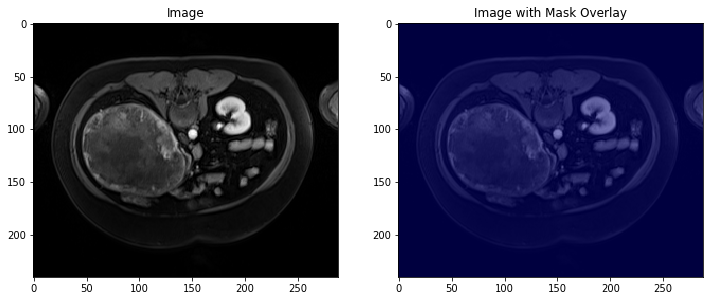

In [9]:
# Plot the image using Matplotlib
plt.figure(figsize=(12, 5))

# Plot the image on the left
plt.subplot(1, 2, 1)
plt.imshow(image_array[38, :, :], cmap='gray')  # Display the first slice of the image
plt.title('Image')

# Plot the mask overlaid on the image on the right
plt.subplot(1, 2, 2)
plt.imshow(image_array[38, :, :], cmap='gray')
plt.imshow(aligned_mask_array[38, :, :], alpha=0.5, cmap='jet')
#plt.imshow(aligned_mask_array[30, :, :], alpha=0.5, cmap='jet')  # Overlay the mask with transparency (alpha)
plt.title('Image with Mask Overlay')

# You can adjust the colormap and other settings as needed
plt.colorbar()
plt.show()

In [5]:
print('image shape:', image_array.shape)
print('resample_mask shape:', aligned_mask_array.shape)
print('mask new shape: ', maskName.shape)

image shape: (112, 240, 288)
resample_mask shape: (112, 240, 288)
mask new shape:  (112, 240, 288)


In [ ]:
#Part 5: Feature extraction: two versions of extraction. 
#first version is for debugging, second one is the final versio with saving results

In [ ]:
#version 1: this is the trace version without saving the feature results
import ipdb
ipdb.set_trace()
extractor = featureextractor.RadiomicsFeatureExtractor('MR_2D_extraction.yaml')

#print('imageName origin: ', imageName.GetOrigin())
#print('imageName spacing: ', imageName.GetSpacing())
#print('imageName direction: ', imageName.GetDirection())
#print('maskName origin: ', maskName.GetOrigin())
#print('maskName spacing: ', maskName.GetSpacing())
#print('maskName direction: ', maskName.GetDirection())

#voxel-based extraction
features = extractor.execute(imageName, aligned_mask, voxelBased=True)
####print('features.keys: ', features.keys()) 

feature_statistics = {}
for key, val in six.iteritems(features):
    if isinstance(val, sitk.Image):  
        # Feature map saved in .nrrd image
        #sitk.WriteImage(val, key + '.nrrd', True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))
        print('key: ', key)
        print('val: ', val)

        # Convert the SimpleITK image to a NumPy array
        parametermap = sitk.GetArrayFromImage(val)
        # Check for NaN values
        if np.isnan(parametermap).any():
              print("Image contains NaN values.")
      
        # Flatten the 2D or 3D image array to calculate statistics
        #parametermap = parameter_map.flatten()
        ##print('parametermap : ', parametermap)
        print('parametermap shape:', parametermap.shape)
        print('parametermap mean:', round(parametermap.mean(),3))
        print('parametermap skew:', round(skew(parametermap.flatten()), 3))
        print('parametermap kurtosis:',round(kurtosis(parametermap.flatten()), 3))
              
        #feature_statistics[key] = val
        #csv_file_path = os.path.join(output_path, key + '.csv')
        # Save the parametermap NumPy array to the .csv file
        #np.savetxt(csv_file_path, parametermap, delimiter=',', fmt='%f')
              
    else: # Diagnostic information
        print("\t%s: %s" %(key, val))


In [ ]:
#version 2: this is the final version with saving the feature results, the setting file is 'Param.yaml'

In [ ]:
#feature extraction for dilation mask 
image_name = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext MinMax norm image/13818504.nii.gz'

# image_name = image_path + folder_name + '.nii.gz'
# print('image_name: ', image_name)

imageName = sitk.ReadImage(image_name)
#print('image size: ', imageName.shape)

# Convert the SimpleITK image to a NumPy array
image_array = sitk.GetArrayFromImage(imageName)
print('image_array.size: ', image_array.size)

###output_path = 'C:/Users/LLI376/Downloads/data_collection/cabo_redo_featureList_correction'
mask_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/dilated_masks/dilated_mask_13818504.nii.gz'
mask = sitk.ReadImage(mask_path)
#mask = nib.load(mask_path)
# Get the image data as a NumPy array
mask_array = sitk.GetArrayFromImage(mask)
#mask_array = mask.get_fdata()

# Print the unique values
print("Unique values in the dilated mask:")
print(np.unique(mask_array))

folder_name = '13818504'

output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_dilation_featureList'

#align mask with volumn
# Get information from the image
image_spacing = imageName.GetSpacing()
image_origin = imageName.GetOrigin()
image_direction = imageName.GetDirection()

# Create a resampling object
resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing(image_spacing)
resampler.SetOutputOrigin(image_origin)
resampler.SetOutputDirection(image_direction)
resampler.SetSize(imageName.GetSize())

# Resample the mask
aligned_mask = resampler.Execute(mask)
aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)

# Get unique values in the msk array
unique_values = np.unique(aligned_mask_array)

# Print the unique values
print("Unique values in the aligned_mask:")
print(unique_values)


extractor = featureextractor.RadiomicsFeatureExtractor('Param.yaml')

#print('imageName origin: ', imageName.GetOrigin())
#print('imageName spacing: ',aligned_mask imageName.GetSpacing())
#print('imageName direction: ', imageName.GetDirection())
#print('maskName origin: ', maskName.GetOrigin())
#print('maskName spacing: ', maskName.GetSpacing())
#print('maskName direction: ', maskName.GetDirection())

#voxel-based extraction
features = extractor.execute(imageName, aligned_mask, voxelBased=True)
####print('features.keys: ', features.keys()) 

feature_statistics = {}
for key, val in six.iteritems(features):
    if isinstance(val, sitk.Image):  
        # Feature map saved in .nrrd image
        #sitk.WriteImage(val, key + '.nrrd', True)
        print("Stored feature %s in %s" % (key, key + ".nrrd"))
        print('key: ', key)
        print('val: ', val)

        # Convert the SimpleITK image to a NumPy array
        parametermap = sitk.GetArrayFromImage(val)
        # Check for NaN values
        if np.isnan(parametermap).any():
              print("Image contains NaN values.")
        
        # Flatten the 2D or 3D image array to calculate statistics
        #parametermap = parameter_map.flatten()
        ##print('parametermap : ', parametermap)
        ##print('parametermap shape:', parametermap.shape)
        ##print('parametermap mean:', round(parametermap.mean(),3))
        ##print('parametermap std:', round(parametermap.std(),3))
        ##print('parametermap skew:', round(skew(parametermap.flatten()), 3))
        ##print('parametermap kurtosis:',round(kurtosis(parametermap.flatten()), 3))
              
        #feature_statistics[key] = val
        #csv_file_path = os.path.join(output_path, key + '.csv')
        # Save the parametermap NumPy array to the .csv file
        #np.savetxt(csv_file_path, parametermap, delimiter=',', fmt='%f')
        F_mean = round(parametermap.mean(),3)
        F_std = round(parametermap.std(), 3)
        F_skewness = round(skew(parametermap.flatten()), 3) # Calculate skewness
        F_kurtosis = round(kurtosis(parametermap.flatten()), 3) # Calculate kurtosis
        #F_skewness = np.mean((parametermap - F_mean) ** 3) / (F_std ** 3)
        #F_kurtosis = np.mean((parametermap - F_mean) ** 4) / (F_std ** 4)

        values_list = [F_mean, F_std, F_skewness, F_kurtosis]
        #values_list.append(parametermap(parametermap>0))   
        print('values_list: ', values_list)
      
        # Store the list of statistics in the dictionary
        feature_statistics[key] = values_list
        ##print('feature_statistics', feature_statistics)
        
        
    else: # Diagnostic information
        print("\t%s: %s" %(key, val))
        
feature_list = os.path.join(output_path, folder_name + '_baseline.csv')
with open(feature_list, 'w') as f:
    for key in feature_statistics.keys():
        f.write("%s,%s\n"%(key,feature_statistics[key]))


In [ ]:
#----------------------------------------------this is the split line------------------------------------------------
#Part 6: --plot histogram for the original, cortext norm, cortext-MinMax norm of all 17 patinets 

In [6]:
#-90667257: the image shape is [288, 248,122] with the kidney mask shape is [720, 620, 575]
import SimpleITK as sitk
path = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/'
for filename in os.listdir(path):
    if filename.endswith('.nii.gz'):
        img_path = os.path.join(path, filename)
        print('img_path: ', img_path)
    if filename.endswith('_Aorta.seg.nrrd'):
        kidney_mask_path = os.path.join(path, filename)
        print('kidney_mask_path: ', kidney_mask_path)
# Load your image and mask
image = sitk.ReadImage(img_path)
mask = sitk.ReadImage(kidney_mask_path)

# Get the image's spacing, origin, and direction
image_spacing = image.GetSpacing()
image_origin = image.GetOrigin()
image_direction = image.GetDirection()

# Set the desired output size to match the image's size
desired_size = image.GetSize()

# Create an identity transform
identity_transform = sitk.Transform(3, sitk.sitkIdentity)

# Apply the transform to the mask
resampled_mask = sitk.Resample(mask, desired_size, identity_transform, sitk.sitkNearestNeighbor, image_origin, image_spacing, image_direction)

# Define the path to save the NRRD file
output_path = "27_ax_vibe_arterial_resample_Aorta.seg.nrrd"

# Save the resampled_mask as an NRRD file
sitk.WriteImage(resampled_mask, os.path.join(path, output_path))

kidney_mask_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/27_ax_vibe_arterial_Aorta.seg.nrrd
img_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/29856335_dilated.nii.gz
img_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/29856335_t1.nii.gz
img_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/27_ax_vibe_arterial.nii.gz
img_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/29856335_cortext1_norm.nii.gz
img_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/29856335/timepoint1/29856335.nii.gz


In [ ]:


#****************************************************************************************#
#modified this part , please run the codes to plot histogram within mask again
#****************************************************************************************#
import matplotlib.pyplot as plt
# Directory containing your .nii files
#data_dir = "/path/to/your/nii/files/"
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'
time_point = '/timepoint2/'
original_output_path =  '/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm/timepoint2'

# Get a list of .nii files in the original images directory
nii_files = [file for file in os.listdir(original_output_path) if file.endswith(".nii.gz")]

# Number of slices to plot from each image
slice_index_to_plot = 42

# Create a single line plot
fig, ax = plt.subplots(figsize=(30, 30))

# Loop through each .nii file and plot the histogram slice on the same plot
for nii_file in nii_files:
    nii_path = os.path.join(original_output_path, nii_file)
    img = nib.load(nii_path)
    data = img.get_fdata()
    
    # Split the filename by '.' to separate the extension
    parts = nii_file.split('.')

    # Extract the first part, which should be the patient id
    if len(parts) > 0:
        folder_name = parts[0]
        print('folder_name：', folder_name)
        
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    for filename in os.listdir(data_dir):
        if filename.endswith('Mass.seg.nrrd'):
            tumor_mask_path = os.path.join(data_dir, filename)
            print('tumor_mask_path: ', tumor_mask_path)
        if filename.endswith('Kidney.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            #print('mask_path: ', mask_path)
            
    #Intensity within kidney 
    #Load the kidney mask (.nrrd)
    mask_data, _ = nrrd.read(mask_path)
    
    #Intensity within tumor
    # Load the tumor area mask (.nrrd)
    tumor_mask_data, _ = nrrd.read(tumor_mask_path)

    # Get the entire slice data
    slice_data = data[:, :, slice_index_to_plot]

    # Extract intensity values within the mask area for the selected slice
    masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

    # Extract intensity values within the tumor area for the selected slice
    tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


    slice_data_kidney = masked_intensity.ravel()
    slice_data_tumor = tumor_intensity.ravel()

    #Filter out non-positive values
    ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
    positive_slice_data = slice_data_tumor[slice_data_tumor > 0]

    #print('positive_slice_data: ', positive_slice_data.min())
    
    # Check if the 'positive_slice_data' array is empty
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 38
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]

    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 25
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 26
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 20
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 34
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]

    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 47
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 23
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 21
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 28
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 31
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        ###positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
    
    
    # Check if there are any 0 values in positive_pixel_values
    if np.min(positive_slice_data) > 0:
        print("There are no 0 values in positive_pixel_values.")
    else:
        print("There are 0 values in positive_pixel_values.")

    # Create X values (pixel values)
    #x_values = np.arange(positive_slice_data.min(), positive_slice_data.max())
    #print('x_values: ',x_values)
    
    # Compute histogram (frequency of each pixel value)
    histogram = np.histogram(positive_slice_data)
    ##print( 'histogram[0]', histogram[0])
    ##print( 'histogram[1]', histogram[1])
    
    ##plt.hist(positive_slice_data, bins=50, color='blue', alpha=0.7)
    
    # Plot the histogram as a line plot
    ax.plot(histogram[1][:-1], histogram[0], label=f'{nii_file} - Slice {slice_index_to_plot}')

# Customize plot labels and legend
ax.set_xlabel('Pixel Value', fontsize=40)
ax.set_ylabel('Frequency', fontsize=40)
ax.set_title(f'Histogram Curves within Tumor on MRI Slice {slice_index_to_plot}', fontsize=50)
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Directory containing your .nii files
#data_dir = "/path/to/your/nii/files/"
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'
time_point = '/timepoint2/'
original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/t2_original_image/'
# Get a list of .nii files in the original images directory
#nii_files = [file for file in os.listdir(original_output_path) if file.endswith(".nii.gz")]

# Define the paths to the directories for Group 1 and Group 2
nii_files = ["53634893Left","53634893Right", "29856335", "87513481", "49121664", "14930122", "88494341"]
#group1_directories = ["42256342", "49121664", "84867994"]
#group2_directories = ["12034721", "29856335", "55990956"]

# Number of slices to plot from each image
slice_index_to_plot = 32

# Create a single line plot
fig, ax = plt.subplots(figsize=(30, 30))

# Loop through each .nii file and plot the histogram slice on the same plot
for nii_file in nii_files:
    nii_path = os.path.join(original_output_path, nii_file + ".nii.gz") # + ".nii.gz")
    img = nib.load(nii_path)
    data = img.get_fdata()
    
    # Split the filename by '.' to separate the extension
    parts = nii_file.split('.')

    # Extract the first part, which should be the patient id
    if len(parts) > 0:
        folder_name = parts[0]
        print('folder_name：', folder_name)
        
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    for filename in os.listdir(data_dir):
        if filename.endswith('Mass.seg.nrrd'):
            tumor_mask_path = os.path.join(data_dir, filename)
            print('tumor_mask_path: ', tumor_mask_path)
        if filename.endswith('Kidney.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            #print('mask_path: ', mask_path)
            
    #Intensity within kidney 
    #Load the kidney mask (.nrrd)
    mask_data, _ = nrrd.read(mask_path)
    
    #Intensity within tumor
    # Load the tumor area mask (.nrrd)
    tumor_mask_data, _ = nrrd.read(tumor_mask_path)

    # Get the entire slice data
    slice_data = data[:, :, slice_index_to_plot]

    # Extract intensity values within the mask area for the selected slice
    masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

    # Extract intensity values within the tumor area for the selected slice
    tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


    slice_data_kidney = masked_intensity.ravel()
    slice_data_tumor = tumor_intensity.ravel()

    #Filter out non-positive values
    positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
    ###positive_slice_data = slice_data_tumor[slice_data_tumor > 0]

    #print('positive_slice_data: ', positive_slice_data.min())
    
    # Check if the 'positive_slice_data' array is empty
    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 25
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        ###positive_slice_data = slice_data_tumor[slice_data_tumor > 0]

    if np.size(positive_slice_data) == 0:
        print("positive_slice_data is empty (null).")
        # Get the entire slice data
        slice_index_to_plot = 42
        slice_data = data[:, :, slice_index_to_plot]

        # Extract intensity values within the mask area for the selected slice
        masked_intensity = slice_data[mask_data[:, :, slice_index_to_plot] == 1]

        # Extract intensity values within the tumor area for the selected slice
        tumor_intensity = slice_data[tumor_mask_data[:, :, slice_index_to_plot] == 1]


        slice_data_kidney = masked_intensity.ravel()
        slice_data_tumor = tumor_intensity.ravel()

        #Filter out non-positive values
        positive_slice_data = slice_data_kidney[slice_data_kidney > 0]
        ###positive_slice_data = slice_data_tumor[slice_data_tumor > 0]
        
    # Check if there are any 0 values in positive_pixel_values
    if np.min(positive_slice_data) > 0:
        print("There are no 0 values in positive_pixel_values.")
    else:
        print("There are 0 values in positive_pixel_values.")

    # Create X values (pixel values)
    #x_values = np.arange(positive_slice_data.min(), positive_slice_data.max())
    #print('x_values: ',x_values)
    
    # Compute histogram (frequency of each pixel value)
    histogram = np.histogram(positive_slice_data)
    ##print( 'histogram[0]', histogram[0])
    ##print( 'histogram[1]', histogram[1])
    
    ##plt.hist(positive_slice_data, bins=50, color='blue', alpha=0.7)
    
    # Plot the histogram as a line plot
    ax.plot(histogram[1][:-1], histogram[0], label=f'{nii_file} - Slice {slice_index_to_plot}')

# Customize plot labels and legend
ax.set_xlabel('Pixel Value', fontsize=40)
ax.set_ylabel('Frequency', fontsize=40)
ax.set_title(f'Histogram Curves within Kidney on MRI Slice {slice_index_to_plot}', fontsize=50)
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()


In [ ]:
cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_minMax_norm/'
# Get a list of .nii files in the directory
nii_files = [file for file in os.listdir(original_output_path) if file.endswith(".nii.gz")]

# Number of slices to plot from each image
slice_index_to_plot = 38

# Create a single line plot
fig, ax = plt.subplots(figsize=(20, 20))

abnormal_img = []
# Loop through each .nii file and plot the histogram slice on the same plot
for nii_file in nii_files:
    nii_path = os.path.join(original_output_path, nii_file)
    ##print('nii_path: ', nii_path)
    img = nib.load(nii_path)
    data = img.get_fdata()

    # Get the slice data
    slice_data = data[:, :, slice_index_to_plot].ravel()
    #print('slice_data: ', slice_data)
    
    # Filter out non-positive values
    positive_slice_data = slice_data[slice_data > 0]
    
    # Check if there are any 0 values in positive_pixel_values
    if np.min(positive_slice_data) > 0:
        print("There are no 0 values in positive_slice_data.")
    else:
        print("There are 0 values in positive_slice_data.")

    # Create X values (pixel values)
    ##x_values = np.arange(positive_slice_data.min(), positive_slice_data.max()+1)
    #print('x_values: ',x_values)
    
    # Compute histogram (frequency of each pixel value)
    histogram = np.histogram(positive_slice_data)
    print('histogram[0]: ', histogram[0])
    print('histogram[1]: ',  histogram[1])

    
#     if any(value > 100000 for value in histogram[0]):
#         print('nii_file: ', nii_file)
#         # Plot the chosen slice
#         ax.imshow(data[:, :, slice_index_to_plot], cmap='gray')  # Adjust the colormap as needed
#         ax.set_title(f'Slice {slice_index_to_plot} - {nii_file}')


    # Plot the histogram as a line plot
    ax.plot(histogram[1][:-1], histogram[0], label=f'{nii_file} - Slice {slice_index_to_plot}')

# Customize plot labels and legend
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histogram Curves of Positive on MRI Slice {slice_index_to_plot}')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project//'
# Get a list of .nii files in the directory
nii_files = [file for file in os.listdir(cortext_norm_output_path) if file.endswith(".nii.gz")]

# Number of slices to plot from each image
slice_index_to_plot = 38

# Create a single line plot
fig, ax = plt.subplots(figsize=(20, 20))

abnormal_img = []
# Loop through each .nii file and plot the histogram slice on the same plot
for nii_file in nii_files:
    nii_path = os.path.join(cortext_norm_output_path, nii_file)
    ##print('nii_path: ', nii_path)
    img = nib.load(nii_path)
    data = img.get_fdata()

    # Get the slice data
    slice_data = data[:, :, slice_index_to_plot].ravel()
    #print('slice_data: ', slice_data)
    
    # Filter out non-positive values
    positive_slice_data = slice_data[slice_data > 0]
    
    # Check if there are any 0 values in positive_pixel_values
    if np.min(positive_slice_data) > 0:
        print("There are no 0 values in positive_slice_data.")
    else:
        print("There are 0 values in positive_slice_data.")

    # Create X values (pixel values)
    ##x_values = np.arange(positive_slice_data.min(), positive_slice_data.max()+1)
    #print('x_values: ',x_values)
    
    # Compute histogram (frequency of each pixel value)
    histogram = np.histogram(positive_slice_data)
    print('histogram[0]: ', histogram[0])
    print('histogram[1]: ',  histogram[1])

    
#     if any(value > 100000 for value in histogram[0]):
#         print('nii_file: ', nii_file)
#         # Plot the chosen slice
#         ax.imshow(data[:, :, slice_index_to_plot], cmap='gray')  # Adjust the colormap as needed
#         ax.set_title(f'Slice {slice_index_to_plot} - {nii_file}')


    # Plot the histogram as a line plot
    ax.plot(histogram[1][:-1], histogram[0], label=f'{nii_file} - Slice {slice_index_to_plot}')

# Customize plot labels and legend
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Frequency')
ax.set_title(f'Histogram Curves of Positive on MRI Slice {slice_index_to_plot}')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
cortext_MinMax_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_norm_t2'
# Get a list of .nii files in the directory
nii_files = [file for file in os.listdir(cortext_MinMax_norm_output_path) if file.endswith(".nii.gz")]

# Number of slices to plot from each image
slice_index_to_plot = 38

# Create a single line plot
fig, ax = plt.subplots(figsize=(20, 20))

# Loop through each .nii file and plot the histogram slice on the same plot
for nii_file in nii_files:
    nii_path = os.path.join(cortext_MinMax_norm_output_path, nii_file)
    img = nib.load(nii_path)
    data = img.get_fdata()

    # Get the slice data
    slice_data = data[:, :, slice_index_to_plot].ravel()

   # Filter out non-positive values
    positive_slice_data = slice_data[slice_data > 0]
    
    # Check if there are any 0 values in positive_pixel_values
    if np.min(positive_slice_data) > 0:
        print("There are no 0 values in positive_pixel_values.")
    else:
        print("There are 0 values in positive_pixel_values.")
        
    # Create X values (pixel values)
    #x_values = np.arange(positive_slice_data.min(), positive_slice_data.max())

    # Compute histogram (frequency of each pixel value)
    #histogram = np.histogram(positive_slice_data, bins=x_values)
    # Compute histogram (frequency of each pixel value) without specifying bins
    histogram = np.histogram(positive_slice_data)
    
    if any(value > 100000 for value in histogram[0]):
        print('nii_file: ', nii_file)
        
    # Plot the histogram as a line plot
    ax.plot(histogram[1][:-1], histogram[0], label=f'{nii_file} - Slice {slice_index_to_plot}')

# Customize plot labels and legend
ax.set_xlabel('Pixel Value', fontsize=40)
ax.set_ylabel('Frequency', fontsize=40)
ax.set_title(f'Histogram Curves on MRI Slice {slice_index_to_plot}', fontsize=50)
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
#---------------------this is the split line------------------------------------------------
#Part 7:plot images with masks for the original, cortext norm, cortext-MinMax norm of two groups(three cases for each)

In [ ]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

#the path to kidney mask & tumor mask 
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentation/'
time_point = '/timepoint1/'

# Define the paths to the directories for Group 1 and Group 2
group1_directories = ["53634893Left","53634893Right", "29856335", "87513481"]
group2_directories = ["49121664", "14930122", "88494341"]

# Define a function to plot an MRI image with masks
def plot_mri_with_masks(image_path, mask1_path, mask2_path):
    # Load the MRI image
    image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(image)

    # Load the masks
    mask1 = sitk.ReadImage(mask1_path)
    mask1_array = sitk.GetArrayFromImage(mask1)

    mask2 = sitk.ReadImage(mask2_path)
    mask2_array = sitk.GetArrayFromImage(mask2)

    # Create a figure and axes for plotting
    fig, ax = plt.subplots()

    # Plot the MRI image
    plt.imshow(image_array[25, :, :], cmap='gray')

    # Plot the mask outlines using contour
    contours1 = plt.contour(mask1_array[25, :, :], levels=[0.5], colors='red', linewidths=1)
    contours2 = plt.contour(mask2_array[20, :, :], levels=[0.5], colors='blue', linewidths=1)

    # Add a legend for mask colors
    ax.legend([contours1.collections[0], contours2.collections[0]], ['Kidney Mask-Red', 'Tumor Mask-Blue'])

    # Customize the plot: labels, title, etc.
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
    plt.title('MRI Image with Masks Outlines')

    # Show the plot or save it to a file
    # plt.show()  # Uncomment to display the plot interactively
    plt.savefig('output_plot.png')  # Uncomment to save the plot to a file

# Iterate through the directories in Group 1
for folder_name in group1_directories:
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(data_dir, filename.replace('Mass.seg.nrrd', '.nii.gz'))
            print('mri_path: ', mri_path)
            
        if filename.endswith('Kidney.seg.nrrd'):
            kidney_mask_path = os.path.join(data_dir, filename)
            print('kidney_mask_path: ', kidney_mask_path)
    
    plot_mri_with_masks(mri_path, kidney_mask_path, mask_path)

# Iterate through the directories in Group 2
for folder_name in group2_directories:
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(data_dir, filename.replace('Mass.seg.nrrd', '.nii.gz'))
            print('mri_path: ', mri_path)
            
        if filename.endswith('Kidney.seg.nrrd'):
            kidney_mask_path = os.path.join(data_dir, filename)
            print('kidney_mask_path: ', kidney_mask_path)
    
    plot_mri_with_masks(mri_path, kidney_mask_path, mask_path)


In [ ]:
#This is for smoothing segmentations

import os
import numpy as np
import cv2 as cv
import nrrd
from matplotlib import pyplot as plt
import nibabel as nib
from scipy.ndimage import gaussian_filter
import scipy
import SimpleITK as sitk

#the path to kidney mask & tumor mask 
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'
time_point = '/timepoint0/'

original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
# cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_norm_t1/'
# cortext_MinMax_norm_output_path ='/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm/timepoint2'

# Define the paths to the directories for Group 1 and Group 2
#group1_directories = ["12034721", "13322994", "13818504","14930122", "28668087", "29856335", "42256342", "49121664", "53459722", "53634893Left", "53634893Right", "53876776", "55990956", "57124737", "84867994","87513481", "88494341","90667257"]
group1_directories = ["90667257"]
#group2_directories = ["49121664", "14930122", "88494341"]

# Define a function to plot an MRI image with masks
def plot_mri_with_masks(mass_path):
    # Load the MRI image
    image = sitk.ReadImage(mass_path)
    image_array = sitk.GetArrayFromImage(image)
    image_array = cv.GaussianBlur(image_array,(5,5), 0)
    
    updated_image = sitk.GetImageFromArray(image_array)
    sitk.WriteImage(updated_image, '/Users/IyerFamMac/Desktop/opencv_project/90667257_smoothed_Mass.seg.nrrd')

    # filename = '12034721_updated.seg.nrrd'
    # nrrd.write(filename, updated_image)

    # Load the masks
    # mask1 = sitk.ReadImage(mask1_path)
    # mask1_array = sitk.GetArrayFromImage(mask1)

    # mask2 = sitk.ReadImage(mask2_path)
    # mask2_array = sitk.GetArrayFromImage(mask2)

    # Create a figure and axes for plotting
    fig, ax = plt.subplots()

    # new_image = sitk.ReadImage(updated_image)
    # updated_image_array = sitk.GetArrayFromImage(new_image)
    

    # Plot the MRI image
    plt.imshow(image_array[25, :, :], cmap='gray')

    # plt.imshow(updated_image_array, cmap='gray')
   

    # Plot the mask outlines using contour
    # contours1 = plt.contour(mask1_array[25, :, :], levels=[0.5], colors='red', linewidths=1)
    # contours2 = plt.contour(mask2_array[25, :, :], levels=[0.5], colors='blue', linewidths=1)

    # # Add a legend for mask colors
    # ax.legend([contours1.collections[0], contours2.collections[0]], ['Kidney Mask-Red', 'Tumor Mask-Blue'])

    # Customize the plot: labels, title, etc.
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
    plt.title('Mass Segmentation at Baseline After Smoothing')

    # Show the plot or save it to a file
    # plt.show()  # Uncomment to display the plot interactively
    # plt.savefig('output_plot.png')  # Uncomment to save the plot to a file

# Iterate through the directories in Group 1
for folder_name in group1_directories:
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            # Filter the list to include only .nii and .nii.gz files
            #mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
            #print('mri_path: ', mri_path)
            
        # if filename.endswith('Kidney.seg.nrrd'):
        #     kidney_mask_path = os.path.join(data_dir, filename)
        #     print('kidney_mask_path: ', kidney_mask_path)
        
    #mri_path = os.path.join(cortext_norm_output_path, folder_name + '.nii.gz')
    # mri_path = os.path.join(original_output_path, folder_name + '.nii.gz')
    # print('mri_path: ', mri_path)
        
    plot_mri_with_masks(mask_path)


In [ ]:
#the path to kidney mask & tumor mask 
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'
time_point = '/timepoint2/'

original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/t2_original_image/'
cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_norm_t1/'
cortext_MinMax_norm_output_path ='/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm/timepoint2'

# Define the paths to the directories for Group 1 and Group 2
group1_directories = ["53634893Left", "53634893Right", "29856335", "87513481"]
group2_directories = ["49121664", "14930122", "88494341"]

# Define a function to plot an MRI image with masks
def plot_mri_with_masks(image_path, mask1_path, mask2_path):
    # Load the MRI image
    image = sitk.ReadImage(image_path)
    image_array = sitk.GetArrayFromImage(image)

    # Load the masks
    mask1 = sitk.ReadImage(mask1_path)
    mask1_array = sitk.GetArrayFromImage(mask1)

    mask2 = sitk.ReadImage(mask2_path)
    mask2_array = sitk.GetArrayFromImage(mask2)

    # Create a figure and axes for plotting
    fig, ax = plt.subplots()

    # Plot the MRI image
    plt.imshow(image_array[25, :, :], cmap='gray')

    # Plot the mask outlines using contour
    contours1 = plt.contour(mask1_array[25, :, :], levels=[0.5], colors='red', linewidths=1)
    contours2 = plt.contour(mask2_array[25, :, :], levels=[0.5], colors='blue', linewidths=1)

    # Add a legend for mask colors
    ax.legend([contours1.collections[0], contours2.collections[0]], ['Kidney Mask-Red', 'Tumor Mask-Blue'])

    # Customize the plot: labels, title, etc.
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
    plt.title('MRI Image with Masks Outlines')

    # Show the plot or save it to a file
    # plt.show()  # Uncomment to display the plot interactively
    plt.savefig('output_plot.png')  # Uncomment to save the plot to a file

# Iterate through the directories in Group 1
for folder_name in group1_directories:
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('_Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            # Filter the list to include only .nii and .nii.gz files
            #mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
            #print('mri_path: ', mri_path)
            
        if filename.endswith('Kidney.seg.nrrd'):
            kidney_mask_path = os.path.join(data_dir, filename)
            print('kidney_mask_path: ', kidney_mask_path)
        
    #mri_path = os.path.join(cortext_norm_output_path, folder_name + '.nii.gz')
    mri_path = os.path.join(original_output_path, folder_name + '.nii.gz')
    print('mri_path: ', mri_path)
        
    plot_mri_with_masks(mri_path, kidney_mask_path, mask_path)

# # Iterate through the directories in Group 2
# for folder_name in group2_directories:
#     folder_path = folder_name + time_point
#     data_dir = dir_root + folder_path
    
#     # Iterate through the dataset  /_Mass.seg.nrrd
#     for filename in os.listdir(data_dir):
#         if filename.endswith('_Mass.seg.nrrd'):
#             mask_path = os.path.join(data_dir, filename)
#             # Filter the list to include only .nii and .nii.gz files
#             #mri_path = os.path.join(data_dir, filename.replace('_Mass.seg.nrrd', '.nii.gz'))
#             #print('mri_path: ', mri_path)
            
#         if filename.endswith('Kidney.seg.nrrd'):
#             kidney_mask_path = os.path.join(data_dir, filename)
#             print('kidney_mask_path: ', kidney_mask_path)
    
#     plot_mri_with_masks(mri_path, kidney_mask_path, mask_path)


In [1]:

import numpy as np
import matplotlib.pyplot as plt

turbo_colormap_data = np.array(
                       [[0.18995,0.07176,0.23217],
                       [0.19483,0.08339,0.26149],
                       [0.19956,0.09498,0.29024],
                       [0.20415,0.10652,0.31844],
                       [0.20860,0.11802,0.34607],
                       [0.21291,0.12947,0.37314],
                       [0.21708,0.14087,0.39964],
                       [0.22111,0.15223,0.42558],
                       [0.22500,0.16354,0.45096],
                       [0.22875,0.17481,0.47578],
                       [0.23236,0.18603,0.50004],
                       [0.23582,0.19720,0.52373],
                       [0.23915,0.20833,0.54686],
                       [0.24234,0.21941,0.56942],
                       [0.24539,0.23044,0.59142],
                       [0.24830,0.24143,0.61286],
                       [0.25107,0.25237,0.63374],
                       [0.25369,0.26327,0.65406],
                       [0.25618,0.27412,0.67381],
                       [0.25853,0.28492,0.69300],
                       [0.26074,0.29568,0.71162],
                       [0.26280,0.30639,0.72968],
                       [0.26473,0.31706,0.74718],
                       [0.26652,0.32768,0.76412],
                       [0.26816,0.33825,0.78050],
                       [0.26967,0.34878,0.79631],
                       [0.27103,0.35926,0.81156],
                       [0.27226,0.36970,0.82624],
                       [0.27334,0.38008,0.84037],
                       [0.27429,0.39043,0.85393],
                       [0.27509,0.40072,0.86692],
                       [0.27576,0.41097,0.87936],
                       [0.27628,0.42118,0.89123],
                       [0.27667,0.43134,0.90254],
                       [0.27691,0.44145,0.91328],
                       [0.27701,0.45152,0.92347],
                       [0.27698,0.46153,0.93309],
                       [0.27680,0.47151,0.94214],
                       [0.27648,0.48144,0.95064],
                       [0.27603,0.49132,0.95857],
                       [0.27543,0.50115,0.96594],
                       [0.27469,0.51094,0.97275],
                       [0.27381,0.52069,0.97899],
                       [0.27273,0.53040,0.98461],
                       [0.27106,0.54015,0.98930],
                       [0.26878,0.54995,0.99303],
                       [0.26592,0.55979,0.99583],
                       [0.26252,0.56967,0.99773],
                       [0.25862,0.57958,0.99876],
                       [0.25425,0.58950,0.99896],
                       [0.24946,0.59943,0.99835],
                       [0.24427,0.60937,0.99697],
                       [0.23874,0.61931,0.99485],
                       [0.23288,0.62923,0.99202],
                       [0.22676,0.63913,0.98851],
                       [0.22039,0.64901,0.98436],
                       [0.21382,0.65886,0.97959],
                       [0.20708,0.66866,0.97423],
                       [0.20021,0.67842,0.96833],
                       [0.19326,0.68812,0.96190],
                       [0.18625,0.69775,0.95498],
                       [0.17923,0.70732,0.94761],
                       [0.17223,0.71680,0.93981],
                       [0.16529,0.72620,0.93161],
                       [0.15844,0.73551,0.92305],
                       [0.15173,0.74472,0.91416],
                       [0.14519,0.75381,0.90496],
                       [0.13886,0.76279,0.89550],
                       [0.13278,0.77165,0.88580],
                       [0.12698,0.78037,0.87590],
                       [0.12151,0.78896,0.86581],
                       [0.11639,0.79740,0.85559],
                       [0.11167,0.80569,0.84525],
                       [0.10738,0.81381,0.83484],
                       [0.10357,0.82177,0.82437],
                       [0.10026,0.82955,0.81389],
                       [0.09750,0.83714,0.80342],
                       [0.09532,0.84455,0.79299],
                       [0.09377,0.85175,0.78264],
                       [0.09287,0.85875,0.77240],
                       [0.09267,0.86554,0.76230],
                       [0.09320,0.87211,0.75237],
                       [0.09451,0.87844,0.74265],
                       [0.09662,0.88454,0.73316],
                       [0.09958,0.89040,0.72393],
                       [0.10342,0.89600,0.71500],
                       [0.10815,0.90142,0.70599],
                       [0.11374,0.90673,0.69651],
                       [0.12014,0.91193,0.68660],
                       [0.12733,0.91701,0.67627],
                       [0.13526,0.92197,0.66556],
                       [0.14391,0.92680,0.65448],
                       [0.15323,0.93151,0.64308],
                       [0.16319,0.93609,0.63137],
                       [0.17377,0.94053,0.61938],
                       [0.18491,0.94484,0.60713],
                       [0.19659,0.94901,0.59466],
                       [0.20877,0.95304,0.58199],
                       [0.22142,0.95692,0.56914],
                       [0.23449,0.96065,0.55614],
                       [0.24797,0.96423,0.54303],
                       [0.26180,0.96765,0.52981],
                       [0.27597,0.97092,0.51653],
                       [0.29042,0.97403,0.50321],
                       [0.30513,0.97697,0.48987],
                       [0.32006,0.97974,0.47654],
                       [0.33517,0.98234,0.46325],
                       [0.35043,0.98477,0.45002],
                       [0.36581,0.98702,0.43688],
                       [0.38127,0.98909,0.42386],
                       [0.39678,0.99098,0.41098],
                       [0.41229,0.99268,0.39826],
                       [0.42778,0.99419,0.38575],
                       [0.44321,0.99551,0.37345],
                       [0.45854,0.99663,0.36140],
                       [0.47375,0.99755,0.34963],
                       [0.48879,0.99828,0.33816],
                       [0.50362,0.99879,0.32701],
                       [0.51822,0.99910,0.31622],
                       [0.53255,0.99919,0.30581],
                       [0.54658,0.99907,0.29581],
                       [0.56026,0.99873,0.28623],
                       [0.57357,0.99817,0.27712],
                       [0.58646,0.99739,0.26849],
                       [0.59891,0.99638,0.26038],
                       [0.61088,0.99514,0.25280],
                       [0.62233,0.99366,0.24579],
                       [0.63323,0.99195,0.23937],
                       [0.64362,0.98999,0.23356],
                       [0.65394,0.98775,0.22835],
                       [0.66428,0.98524,0.22370],
                       [0.67462,0.98246,0.21960],
                       [0.68494,0.97941,0.21602],
                       [0.69525,0.97610,0.21294],
                       [0.70553,0.97255,0.21032],
                       [0.71577,0.96875,0.20815],
                       [0.72596,0.96470,0.20640],
                       [0.73610,0.96043,0.20504],
                       [0.74617,0.95593,0.20406],
                       [0.75617,0.95121,0.20343],
                       [0.76608,0.94627,0.20311],
                       [0.77591,0.94113,0.20310],
                       [0.78563,0.93579,0.20336],
                       [0.79524,0.93025,0.20386],
                       [0.80473,0.92452,0.20459],
                       [0.81410,0.91861,0.20552],
                       [0.82333,0.91253,0.20663],
                       [0.83241,0.90627,0.20788],
                       [0.84133,0.89986,0.20926],
                       [0.85010,0.89328,0.21074],
                       [0.85868,0.88655,0.21230],
                       [0.86709,0.87968,0.21391],
                       [0.87530,0.87267,0.21555],
                       [0.88331,0.86553,0.21719],
                       [0.89112,0.85826,0.21880],
                       [0.89870,0.85087,0.22038],
                       [0.90605,0.84337,0.22188],
                       [0.91317,0.83576,0.22328],
                       [0.92004,0.82806,0.22456],
                       [0.92666,0.82025,0.22570],
                       [0.93301,0.81236,0.22667],
                       [0.93909,0.80439,0.22744],
                       [0.94489,0.79634,0.22800],
                       [0.95039,0.78823,0.22831],
                       [0.95560,0.78005,0.22836],
                       [0.96049,0.77181,0.22811],
                       [0.96507,0.76352,0.22754],
                       [0.96931,0.75519,0.22663],
                       [0.97323,0.74682,0.22536],
                       [0.97679,0.73842,0.22369],
                       [0.98000,0.73000,0.22161],
                       [0.98289,0.72140,0.21918],
                       [0.98549,0.71250,0.21650],
                       [0.98781,0.70330,0.21358],
                       [0.98986,0.69382,0.21043],
                       [0.99163,0.68408,0.20706],
                       [0.99314,0.67408,0.20348],
                       [0.99438,0.66386,0.19971],
                       [0.99535,0.65341,0.19577],
                       [0.99607,0.64277,0.19165],
                       [0.99654,0.63193,0.18738],
                       [0.99675,0.62093,0.18297],
                       [0.99672,0.60977,0.17842],
                       [0.99644,0.59846,0.17376],
                       [0.99593,0.58703,0.16899],
                       [0.99517,0.57549,0.16412],
                       [0.99419,0.56386,0.15918],
                       [0.99297,0.55214,0.15417],
                       [0.99153,0.54036,0.14910],
                       [0.98987,0.52854,0.14398],
                       [0.98799,0.51667,0.13883],
                       [0.98590,0.50479,0.13367],
                       [0.98360,0.49291,0.12849],
                       [0.98108,0.48104,0.12332],
                       [0.97837,0.46920,0.11817],
                       [0.97545,0.45740,0.11305],
                       [0.97234,0.44565,0.10797],
                       [0.96904,0.43399,0.10294],
                       [0.96555,0.42241,0.09798],
                       [0.96187,0.41093,0.09310],
                       [0.95801,0.39958,0.08831],
                       [0.95398,0.38836,0.08362],
                       [0.94977,0.37729,0.07905],
                       [0.94538,0.36638,0.07461],
                       [0.94084,0.35566,0.07031],
                       [0.93612,0.34513,0.06616],
                       [0.93125,0.33482,0.06218],
                       [0.92623,0.32473,0.05837],
                       [0.92105,0.31489,0.05475],
                       [0.91572,0.30530,0.05134],
                       [0.91024,0.29599,0.04814],
                       [0.90463,0.28696,0.04516],
                       [0.89888,0.27824,0.04243],
                       [0.89298,0.26981,0.03993],
                       [0.88691,0.26152,0.03753],
                       [0.88066,0.25334,0.03521],
                       [0.87422,0.24526,0.03297],
                       [0.86760,0.23730,0.03082],
                       [0.86079,0.22945,0.02875],
                       [0.85380,0.22170,0.02677],
                       [0.84662,0.21407,0.02487],
                       [0.83926,0.20654,0.02305],
                       [0.83172,0.19912,0.02131],
                       [0.82399,0.19182,0.01966],
                       [0.81608,0.18462,0.01809],
                       [0.80799,0.17753,0.01660],
                       [0.79971,0.17055,0.01520],
                       [0.79125,0.16368,0.01387],
                       [0.78260,0.15693,0.01264],
                       [0.77377,0.15028,0.01148],
                       [0.76476,0.14374,0.01041],
                       [0.75556,0.13731,0.00942],
                       [0.74617,0.13098,0.00851],
                       [0.73661,0.12477,0.00769],
                       [0.72686,0.11867,0.00695],
                       [0.71692,0.11268,0.00629],
                       [0.70680,0.10680,0.00571],
                       [0.69650,0.10102,0.00522],
                       [0.68602,0.09536,0.00481],
                       [0.67535,0.08980,0.00449],
                       [0.66449,0.08436,0.00424],
                       [0.65345,0.07902,0.00408],
                       [0.64223,0.07380,0.00401],
                       [0.63082,0.06868,0.00401],
                       [0.61923,0.06367,0.00410],
                       [0.60746,0.05878,0.00427],
                       [0.59550,0.05399,0.00453],
                       [0.58336,0.04931,0.00486],
                       [0.57103,0.04474,0.00529],
                       [0.55852,0.04028,0.00579],
                       [0.54583,0.03593,0.00638],
                       [0.53295,0.03169,0.00705],
                       [0.51989,0.02756,0.00780],
                       [0.50664,0.02354,0.00863],
                       [0.49321,0.01963,0.00955],
                       [0.47960,0.01583,0.01055]])




def RGBToPyCmap(rgbdata):
    nsteps = rgbdata.shape[0]
    stepaxis = np.linspace(0, 1, nsteps)

    rdata=[]; gdata=[]; bdata=[]
    for istep in range(nsteps):
        r = rgbdata[istep,0]
        g = rgbdata[istep,1]
        b = rgbdata[istep,2]
        rdata.append((stepaxis[istep], r, r))
        gdata.append((stepaxis[istep], g, g))
        bdata.append((stepaxis[istep], b, b))

    mpl_data = {'red':   rdata,
                 'green': gdata,
                 'blue':  bdata}

    return mpl_data


mpl_data = RGBToPyCmap(turbo_colormap_data)
plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])

mpl_data_r = RGBToPyCmap(turbo_colormap_data[::-1,:])
plt.register_cmap(name='turbo_r', data=mpl_data_r, lut=turbo_colormap_data.shape[0])



if __name__=='__main__':

    XX, YY = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
    ZZ = np.sqrt(XX**2 + YY**2)

    plt.figure()
    plt.imshow(ZZ, cmap='turbo')
    plt.colorbar()

    plt.figure()
    plt.imshow(ZZ, cmap='turbo_r')
    plt.colorbar()
    
    plt.show()


/var/folders/rn/dd433nv542s_qp74q6y99g740000gn/T/ipykernel_73943/840751669.py:286: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='turbo', data=mpl_data, lut=turbo_colormap_data.shape[0])


TypeError: register_cmap() got an unexpected keyword argument 'data'

In [ ]:
#Part8: plot intratumoral feature heatmap 

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import SimpleITK as sitk
import os
import nibabel as nib
from scipy import ndimage as ndi
import six
from scipy import stats
from scipy.stats import skew, kurtosis
from radiomics import featureextractor, getTestCase
from pathlib import Path
import nrrd 
import sklearn
from sklearn.preprocessing import MinMaxScaler

dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'
folder_name = '13322994'
data_dir = '/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm_revised/13322994/timepoint0/'

# Create a custom colormap based on the Turbo colormap
turbo_cmap = plt.get_cmap('turbo')

# Define the value for which you want to make the color transparent
transparent_value = 0

# Create a new colormap with transparency
colors = turbo_cmap(np.linspace(0, 1, 256))
colors[transparent_value] = (0, 0, 0, 0)  # Set alpha (transparency) to 0
custom_cmap = LinearSegmentedColormap.from_list('custom_turbo', colors, N=256)


nii_file_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm/timepoint0/'

# # Get a list of all subdirectories in the main directory
# subdirectories = [f for f in os.listdir(dir_root) if os.path.isdir(os.path.join(dir_root, f))]
# print('folder_names shape: ', len(subdirectories))
# print('folder_names: ', subdirectories)
 
# # Loop through each subdirectory
# for folder_name in subdirectories:
#     time_point = '/timepoint0/'
#     folder_path = folder_name + time_point
#     data_dir = dir_root + folder_path
    # Iterate through the dataset  /_Mass.seg.nrrd
for filename in os.listdir(data_dir):
    if filename.endswith('_Mass.seg.nrrd'):
        mask_path = os.path.join(data_dir, filename)
        print('mask_path: ', mask_path)
        
        # Filter the list to include only .nii and .nii.gz files
        mri_path = os.path.join(nii_file_path, '13322994.nii.gz')
        print('mri_path: ', mri_path)

imageName = sitk.ReadImage(mri_path)
# Convert the SimpleITK image to a NumPy array
image_array = sitk.GetArrayFromImage(imageName)
print('image_array shape: ', image_array.shape)

mask = sitk.ReadImage(mask_path)
#mask = nib.load(mask_path)
# Get the image data as a NumPy array
mask_array = sitk.GetArrayFromImage(mask)
#mask_array = mask.get_fdata()

# Print the unique values
print("Unique values in the dilated mask:")
print(np.unique(mask_array))

#align mask with volumn
# Get information from the image
image_spacing = imageName.GetSpacing()
image_origin = imageName.GetOrigin()
image_direction = imageName.GetDirection()

# Create a resampling object
resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing(image_spacing)
resampler.SetOutputOrigin(image_origin)
resampler.SetOutputDirection(image_direction)
resampler.SetSize(imageName.GetSize())

# Resample the mask
aligned_mask = resampler.Execute(mask)
aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)
print('aligned mask shape: ', aligned_mask_array.shape)

# Get unique values in the msk array
unique_values = np.unique(aligned_mask_array)

# Print the unique values
print("Unique values in the aligned_mask:")
print(unique_values)

extractor = featureextractor.RadiomicsFeatureExtractor('Param.yaml')

#voxel-based extraction
features = extractor.execute(imageName, aligned_mask, voxelBased=True)
print('features.keys: ', len(features)) 

# slice_num, x, y = np.where(aligned_mask!=0)
# slices = np.unique(slice_num)
# print('slices: ', slices)

masks = aligned_mask_array[25, :, :]


# feature_statistics = {'log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis_skew, log-sigma-1-0-mm-3D_glcm_Correlation_std, log-sigma-1-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis_mean, log-sigma-1-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_mean, log-sigma-1-0-mm-3D_gldm_LargeDependenceEmphasis_std,log-sigma-1-0-mm-3D_glszm_LargeAreaEmphasis_std, log-sigma-1-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_ZoneVariance_std, log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis_kur, log-sigma-1-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis_mean, log-sigma-1-0-mm-3D_glcm_JointEnergy_std, log-sigma-1-0-mm-3D_glcm_ClusterShade_std, log-sigma-1-0-mm-3D_glrlm_LongRunEmphasis_std, log-sigma-5-0-mm-3D_glcm_ClusterShade_skew, log-sigma-1-0-mm-3D_glrlm_RunVariance_std, log-sigma-1-0-mm-3D_glcm_MaximumProbability_std, log-sigma-1-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis_mean'}
key = 'log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis_skew, log-sigma-1-0-mm-3D_glcm_Correlation_std, log-sigma-1-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis_mean, log-sigma-1-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_mean, log-sigma-1-0-mm-3D_gldm_LargeDependenceEmphasis_std,log-sigma-1-0-mm-3D_glszm_LargeAreaEmphasis_std, log-sigma-1-0-mm-3D_glrlm_LongRunLowGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_ZoneVariance_std, log-sigma-1-0-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis_kur, log-sigma-1-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_LargeAreaLowGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis_mean, log-sigma-1-0-mm-3D_glcm_JointEnergy_std, log-sigma-1-0-mm-3D_glcm_ClusterShade_std, log-sigma-1-0-mm-3D_glrlm_LongRunEmphasis_std, log-sigma-5-0-mm-3D_glcm_ClusterShade_skew, log-sigma-1-0-mm-3D_glrlm_RunVariance_std, log-sigma-1-0-mm-3D_glcm_MaximumProbability_std, log-sigma-1-0-mm-3D_glrlm_ShortRunHighGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_glszm_SmallAreaHighGrayLevelEmphasis_std, log-sigma-1-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis_mean'
for key, val in six.iteritems(features):
    if isinstance(val, sitk.Image):  
        ###############################################################
    #You can set the 'key' as the 25 features mentioned in the email.
    ###############################################################


        # Convert the SimpleITK image to a NumPy array
        parametermap = sitk.GetArrayFromImage(val)
        print('parametermap shape: ', parametermap.shape)
        # Check for NaN values
        if np.isnan(parametermap).any():
                print("Image contains NaN values.")
        
        print('key: ', key)
        
        ####part 1: plot the heatmap and overlay features 
        scaler_feature = MinMaxScaler()
        heatmap_data = scaler_feature.fit_transform(parametermap[13, :, :])
        print('heatmap_data shape: ', heatmap_data.shape)
                    
        masks = masks.astype('float64')
        masks[masks==1.0] = heatmap_data[heatmap_data!=0]
        masks[masks==0.0] = None
        
        # Plot the MRI image for a slice
        plt.imshow(image_array[25, :, :], cmap='gray')
        plt.imshow(masks,cmap=custom_cmap,  alpha=0.9)
        
        # Plot the mask outlines using contour
        #contours1 = plt.contour(masks, levels=[0.5], colors='red', linewidths=1)
        #plt.xlabel('X-axis')
        #plt.ylabel('Y-axis')
        plt.title('Features Overlay on Heatmap')
        #plt.imshow(img,'turbo', alpha =0.7)
        plt.colorbar() 
        plt.pause(0.25) 
        plt.close()
        #cbar = plt.colorbar()
        #cbar.set_label('Heatmap Intensity')
        #plt.show()
        # Save the plot to a file (e.g., PNG, PDF, SVG, etc.)
        ###plt.savefig(f'{file_name}_{feature}_map.png')  # Specify the desired file format (e.g., 'boxplot.pdf' for PDF)



# data_dir = '/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm_revised/'
# folder_name= '12034721'
# time_point = '/timepoint0/'
# data_dir = data_dir + folder_name + time_point

# image_path = '/Users/IyerFamMac/Desktop/opencv_project/'
# image_name = folder_name + '.nii.gz'
# print('image_name: ', image_name)

# #imageName = sitk.ReadImage(image_name)
# imageName = sitk.ReadImage(os.path.join(data_dir, '12034721.nii.gz'))

# output_path = '/Users/IyerFamMac/Desktop/opencv_project/'



#     # Load your image and mask
# image = sitk.ReadImage(mri_path)
# mask = sitk.ReadImage(mask_path)

# Get the image's spacing, origin, and direction
# image_spacing = image.GetSpacing()
# image_origin = image.GetOrigin()
# image_direction = image.GetDirection()

# # Set the desired output size to match the image's size
# desired_size = image.GetSize()

# # Create an identity transform
# identity_transform = sitk.Transform(3, sitk.sitkIdentity)

# # Apply the transform to the mask
# resampled_mask = sitk.Resample(mask, desired_size, identity_transform, sitk.sitkNearestNeighbor, image_origin, image_spacing, image_direction)

# # Define the path to save the NRRD file
# output_path = "11_ax_svibe_arterial_resample_Kidney.seg.nrrd"

# Save the resampled_mask as an NRRD file
# sitk.WriteImage(resampled_mask, os.path.join(path, output_path))



In [3]:
##Part8: plot intratumoral feature heatmap 

from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.interpolate import interp2d

# Create a custom colormap based on the Turbo colormap
turbo_cmap = plt.get_cmap('turbo')

# Define the value for which you want to make the color transparent
transparent_value = 0

# Create a new colormap with transparency
colors = turbo_cmap(np.linspace(0, 1, 256))
colors[transparent_value] = (0, 0, 0, 0)  # Set alpha (transparency) to 0
custom_cmap = LinearSegmentedColormap.from_list('custom_turbo', colors, N=256)


nii_file_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_MinMax_norm/timepoint0/'
 
# Loop through each subdirectory
for folder_name in subdirectories:
    time_point = '/timepoint0/'
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('_Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            print('mask_path: ', mask_path)
            
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(nii_file_path, folder_name+'.nii.gz')
            print('mri_path: ', mri_path)

    imageName = sitk.ReadImage(mri_path)
    # Convert the SimpleITK image to a NumPy array
    image_array = sitk.GetArrayFromImage(imageName)
    print('image_array shape: ', image_array.shape)

    mask = sitk.ReadImage(mask_path)
    #mask = nib.load(mask_path)
    # Get the image data as a NumPy array
    mask_array = sitk.GetArrayFromImage(mask)
    #mask_array = mask.get_fdata()

    # Print the unique values
    print("Unique values in the dilated mask:")
    print(np.unique(mask_array))

    #align mask with volumn
    # Get information from the image
    image_spacing = imageName.GetSpacing()
    image_origin = imageName.GetOrigin()
    image_direction = imageName.GetDirection()

    # Create a resampling object
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(image_spacing)
    resampler.SetOutputOrigin(image_origin)
    resampler.SetOutputDirection(image_direction)
    resampler.SetSize(imageName.GetSize())

    # Resample the mask
    aligned_mask = resampler.Execute(mask)
    aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)

    # Get unique values in the msk array
    unique_values = np.unique(aligned_mask_array)

    # Print the unique values
    print("Unique values in the aligned_mask:")
    print(unique_values)

    extractor = featureextractor.RadiomicsFeatureExtractor('Param.yaml')

    #voxel-based extraction
    features = extractor.execute(imageName, aligned_mask, voxelBased=True)
    print('features.keys: ', len(features)) 

#     slice_num, x, y = np.where(aligned_mask!=0)
#     slices = np.unique(slice_num)
#     print('slices: ', slices)
    
    masks = aligned_mask_array[25, :, :]

    feature_statistics = {}
    for key, val in six.iteritems(features):
        if isinstance(val, sitk.Image):  
            ###############################################################
	    #You can set the 'key' as the 25 features mentioned in the email.
	    ###############################################################


            # Convert the SimpleITK image to a NumPy array
            parametermap = sitk.GetArrayFromImage(val)
            print('parametermap shape: ', parametermap.shape)
            # Check for NaN values
            if np.isnan(parametermap).any():
                  print("Image contains NaN values.")
            
            print('key: ', key)
            
            ####part 1: plot the heatmap and overlay features 
            scaler_feature = MinMaxScaler()
            heatmap_data = scaler_feature.fit_transform(parametermap[21, :, :])
            print('heatmap_data shape: ', heatmap_data.shape)

            # Interpolate heatmap_data to match the size of masks
            interp_func = interp2d(np.arange(heatmap_data.shape[1]), np.arange(heatmap_data.shape[0]), heatmap_data, kind='linear')
            x_new = np.linspace(0, heatmap_data.shape[1] - 1, masks.shape[1])
            y_new = np.linspace(0, heatmap_data.shape[0] - 1, masks.shape[0])
            heatmap_data_resized = interp_func(x_new, y_new)
                       
            masks = masks.astype('float64')
            masks = np.where(masks == 1.0, heatmap_data, masks)
            masks = np.where(masks == 0.0, None, masks)
            masks[masks==1.0] = heatmap_data[heatmap_data!=0]
            masks[masks==0.0] = None
            
            # Plot the MRI image for a slice
            plt.imshow(image_array[25, :, :], cmap='gray')
            plt.imshow(masks,cmap=custom_cmap,  alpha=0.9)
            
            # Plot the mask outlines using contour
            #contours1 = plt.contour(masks, levels=[0.5], colors='red', linewidths=1)
            #plt.xlabel('X-axis')
            #plt.ylabel('Y-axis')
            plt.title('Features Overlay on Heatmap')
            #plt.imshow(img,'turbo', alpha =0.7)
            plt.colorbar() 
            plt.pause(0.25) 
            plt.close()
            #cbar = plt.colorbar()
            #cbar.set_label('Heatmap Intensity')
            #plt.show()
            # Save the plot to a file (e.g., PNG, PDF, SVG, etc.)
            ###plt.savefig(f'{file_name}_{feature}_map.png')  # Specify the desired file format (e.g., 'boxplot.pdf' for PDF)


NameError: name 'subdirectories' is not defined

In [ ]:
#Following parts are for feature extraction and to draw heatmaps

In [2]:
#Part 1 : load each image and do cortex normalization and Min-Max normalization
import os
import numpy as np
import nibabel as nib
import nrrd
from radiomics import featureextractor, getFeatureClasses
import SimpleITK as sitk
import six  # Ensure you have the 'six' library installed for Python 3 compatibility
#import seaborn as sns
import pandas as pd
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap

#Part 1: load dataset for feature extraction and heatmap drawing
# Directory containing MRI images and masks
#corrected dataset
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'

original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
# cortext_MinMax_norm_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext MinMax norm image/t1/'
#######aorta_norm_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/aorta norm image/'

# Get a list of all subdirectories in the main directory
subdirectories = [f for f in os.listdir(dir_root) if os.path.isdir(os.path.join(dir_root, f))]
print('folder_names shape: ', len(subdirectories))
print('folder_names: ', subdirectories)


folder_names shape:  19
folder_names:  ['53459722', '13818504', '53634893Right', '14930122', '87513481', '84867994', '88494341', '53876776', '28668087', '53634893', '57124737', '42256342', '29856335', '13322994', '55990956', '12034721', '53634893Left', '90667257', '49121664']


In [4]:
#Part 2: feature extraction and record each feature for each patient
##feature extraction for each mri and mask pair, and record the Min, Max vallues for each feature
nii_file_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_norm/cortext_norm_t1/'

feature_statistics = {}

feature_min = {}
feature_max = {}

# feature_list = ['wavelet-LH_ngtdm_Busyness, wavelet-HH_glcm_ClusterShade,wavelet-HH_firstorder_Skewness, log-sigma-2-0-mm-3D_firstorder_Maximum, log-sigma-5-0-mm-3D_glszm_GrayLevelNonUniformityNormalized']
# Loop through each subdirectory
for folder_name in subdirectories:
    time_point = '/timepoint1/'
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            print('mask_path: ', mask_path)
            
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(nii_file_path, folder_name+'.nii.gz')
            print('mri_path: ', mri_path)

    imageName = sitk.ReadImage(mri_path)
    # Convert the SimpleITK image to a NumPy array
    image_array = sitk.GetArrayFromImage(imageName)
    print('image_array shape: ', image_array.shape)

    mask = sitk.ReadImage(mask_path)
    #mask = nib.load(mask_path)
    # Get the image data as a NumPy array
    mask_array = sitk.GetArrayFromImage(mask)
    #mask_array = mask.get_fdata()

    # Print the unique values
    print("Unique values in the dilated mask:")
    print(np.unique(mask_array))

    #align mask with volumn
    # Get information from the image
    image_spacing = imageName.GetSpacing()
    image_origin = imageName.GetOrigin()
    image_direction = imageName.GetDirection()

    # Create a resampling object
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(image_spacing)
    resampler.SetOutputOrigin(image_origin)
    resampler.SetOutputDirection(image_direction)
    resampler.SetSize(imageName.GetSize())

    # Resample the mask
    aligned_mask = resampler.Execute(mask)
    aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)

    # Get unique values in the msk array
    unique_values = np.unique(aligned_mask_array)

    # Print the unique values
    print("Unique values in the aligned_mask:")
    print(unique_values)

    extractor = featureextractor.RadiomicsFeatureExtractor('Param.yaml')

    #voxel-based extraction
    features = extractor.execute(imageName, aligned_mask, voxelBased=True)
    print('features keys length: ', len(features)) 

    #     #print mask values and shape
    #     slice_num, x, y = np.where(aligned_mask!=0)
    #     slices = np.unique(slice_num)
    #     print('slices: ', slices)
    #generate heatmaps for all slice where there is a mask. (sum_mask is >0 )
    # Select slices where the mask value is not all zero
    non_zero_slices = np.any(aligned_mask_array != 0, axis=(1, 2))

    # Get the indices of non-zero slices
    non_zero_slice_indices = np.where(non_zero_slices)[0]

    vmin = {}
    vmax = {}
    for key, val in six.iteritems(features):
        #print('key: ', key)
        #print('key type: ', type(key))
        
        #if isinstance(val, sitk.Image) and key in feature_split_results.values: 
        if isinstance(val, sitk.Image): 
        # if key in selected_features:
            print('Feature found!!!!!')
            print('key: ', key)

            ###part 1: resampling the featurmap as the mask shape!!!!!!!!!!!!!!!!!!!!
            rif = sitk.ResampleImageFilter()
            #rif.SetInterpolator(sitk.sitkNearestNeighbor)
            #rif.SetInterpolator(sitk.sitkLinear)
            rif.SetInterpolator(sitk.sitkBSpline)
            rif.SetReferenceImage(aligned_mask)
            val_new = rif.Execute(val)

            # Convert the SimpleITK image to a NumPy array
            parametermap = sitk.GetArrayFromImage(val_new)
            print('parametermap shape: ', parametermap.shape)
            # Check for NaN values
            if np.isnan(parametermap).any():
                    print("Image contains NaN values.")

            # Get the min and max values from flattened_array
            vmin[key] = round(np.nanmin(parametermap),3)
            vmax[key] = round(np.nanmax(parametermap),3)
            print(f'vmin {key}: ', vmin[key])
            print(f'vmax {key}: ', vmax[key])
            
            # Ensure the key is present in feature_min and feature_max
            if key not in feature_min:
                feature_min[key] = vmin[key]
                feature_max[key] = vmax[key]
            else:
                # Update feature_min and feature_max
                if vmin[key] < feature_min[key]:
                    feature_min[key] = vmin[key]
                if vmax[key] > feature_max[key]:
                    feature_max[key] = vmax[key]
                
            feature_statistics[key] = [feature_min[key], feature_max[key]] 
                
    print('feature_min: ', feature_min)    
    print('feature_max:', feature_max)     

    # Assuming feature_min and feature_max are dictionaries
    feature_min_df = pd.DataFrame(list(feature_min.items()), columns=['Feature', 'Min'])
    feature_max_df = pd.DataFrame(list(feature_max.items()), columns=['Feature', 'Max'])
    # Concatenate feature_min_df and feature_max_df along the rows
    ##result_df = pd.concat([feature_min_df, feature_max_df], axis=0, ignore_index=True)
    result_df = pd.merge(feature_min_df, feature_max_df, on='Feature')

    # Save the concatenated data frame to an Excel file
    result_df.to_excel(f'/Users/IyerFamMac/Desktop/opencv_project/{folder_name}_feature_minmax.xlsx', index=False)   

    ##feature_statistics[key] = [feature_min[key], feature_max[key]]    

    print(f'feature_statistics{key}: ', feature_statistics[key])


mask_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/53459722/timepoint1/26_ax_vibe__t1_arterial_Mass.seg.nrrd
mri_path:  /Users/IyerFamMac/Desktop/opencv_project/cortext_norm/cortext_norm_t1/53459722.nii.gz
image_array shape:  (104, 240, 288)
Unique values in the dilated mask:
[0 1]
Unique values in the aligned_mask:
[0 1]
features keys length:  710
Feature found!!!!!
key:  original_firstorder_10Percentile
parametermap shape:  (104, 240, 288)
vmin original_firstorder_10Percentile:  -0.0
vmax original_firstorder_10Percentile:  1.029
Feature found!!!!!
key:  original_firstorder_90Percentile
parametermap shape:  (104, 240, 288)
vmin original_firstorder_90Percentile:  -0.0
vmax original_firstorder_90Percentile:  1.348
Feature found!!!!!
key:  original_firstorder_Energy
parametermap shape:  (104, 240, 288)
vmin original_firstorder_Energy:  -0.0
vmax original_firstorder_Energy:  31.708
Feature found!!!!!
key:  original_firstorder_Entropy
parametermap shape:  (104, 

ModuleNotFoundError: No module named 'openpyxl'

In [5]:
# Part 3: get the min-max values for each featture
#select the max and min for each feature
import pandas as pd
import os

# Specify the folder containing the Excel files
folder_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_norm_t1_spreadsheets/'

# Initialize an empty dictionary to store aggregated 'Max' values for each feature
max_values = {}
min_values = {}

# Iterate through each Excel file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        # Construct the full path to the Excel file
        file_path = os.path.join(folder_path, filename)

        # Read the Excel file into a DataFrame
        df = pd.read_excel(file_path)
        print('Patient id: ' + filename + df.columns)

        # Iterate through each row in the DataFrame
        for index, row in df.iterrows():
            feature = row['Feature']
            max_value = row['Max']
            min_value = row['Min']

            # Update the maximum value for the current feature
            if feature not in max_values or max_value > max_values[feature]:
                max_values[feature] = max_value
            
            # Update the minimum value for the current feature
            if feature not in min_values or min_value < min_values[feature]:
                min_values[feature] = min_value
                
# Create a DataFrame from the aggregated maximum and minimum values 
max_values_df = pd.DataFrame(list(max_values.items()), columns=['Feature', 'Max'])
min_values_df = pd.DataFrame(list(min_values.items()), columns=['Feature', 'Min'])
minmax_df = pd.merge(min_values_df, max_values_df, on='Feature')
  
print('MinMax list: ', minmax_df)
# Save the result to an Excel file
#minmax_df.to_excel('max_values_across_files.xlsx', index=False)

Index(['Patient id: 53634893Right_feature_minmax.xlsxFeature',
       'Patient id: 53634893Right_feature_minmax.xlsxMin',
       'Patient id: 53634893Right_feature_minmax.xlsxMax'],
      dtype='object')
Index(['Patient id: 57124737_feature_minmax.xlsxFeature',
       'Patient id: 57124737_feature_minmax.xlsxMin',
       'Patient id: 57124737_feature_minmax.xlsxMax'],
      dtype='object')
Index(['Patient id: 49121664_feature_minmax.xlsxFeature',
       'Patient id: 49121664_feature_minmax.xlsxMin',
       'Patient id: 49121664_feature_minmax.xlsxMax'],
      dtype='object')
Index(['Patient id: 53876776_feature_minmax.xlsxFeature',
       'Patient id: 53876776_feature_minmax.xlsxMin',
       'Patient id: 53876776_feature_minmax.xlsxMax'],
      dtype='object')
Index(['Patient id: 42256342_feature_minmax.xlsxFeature',
       'Patient id: 42256342_feature_minmax.xlsxMin',
       'Patient id: 42256342_feature_minmax.xlsxMax'],
      dtype='object')
Index(['Patient id: 12034721_feature_min

In [7]:
#Part 4: feature extraction and draw heatmaps for each feature

#Part 1 : load each image and do cortex normalization and Min-Max normalization
import os
import numpy as np
import nibabel as nib
import nrrd
from radiomics import featureextractor, getFeatureClasses
import SimpleITK as sitk
import six  # Ensure you have the 'six' library installed for Python 3 compatibility
import seaborn as sns
import pandas as pd
import scipy.ndimage
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LinearSegmentedColormap

#Part 1: load dataset for feature extraction and heatmap drawing
# Directory containing MRI images and masks
#corrected dataset
dir_root = '/Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/'

original_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
cortext_norm_output_path = '/Users/IyerFamMac/Desktop/opencv_project/'
# cortext_MinMax_norm_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext MinMax norm image/t1/'
#######aorta_norm_output_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/aorta norm image/'

# Get a list of all subdirectories in the main directory
subdirectories = [f for f in os.listdir(dir_root) if os.path.isdir(os.path.join(dir_root, f))]
print('folder_names shape: ', len(subdirectories))
print('folder_names: ', subdirectories)


from matplotlib.ticker import FormatStrFormatter
#nii_file_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext MinMax norm image/'
##nii_file_path = 'C:/Users/LLI376/OneDrive - Emory University/projects/Kidney Project/Cabo project/Cabo_Update/cabo_updated_data/cortext norm image/'
nii_file_path = '/Users/IyerFamMac/Desktop/opencv_project/cortext_norm/cortext_norm_t1/'
# Loop through each subdirectory
for folder_name in subdirectories:
    time_point = '/timepoint1/'
    folder_path = folder_name + time_point
    data_dir = dir_root + folder_path
    
    # Iterate through the dataset  /_Mass.seg.nrrd
    for filename in os.listdir(data_dir):
        if filename.endswith('_Mass.seg.nrrd'):
            mask_path = os.path.join(data_dir, filename)
            print('mask_path: ', mask_path)
            
            # Filter the list to include only .nii and .nii.gz files
            mri_path = os.path.join(nii_file_path, folder_name+'.nii.gz')
            print('mri_path: ', mri_path)

    imageName = sitk.ReadImage(mri_path)
    # Convert the SimpleITK image to a NumPy array
    image_array = sitk.GetArrayFromImage(imageName)
    print('image_array shape: ', image_array.shape)

    mask = sitk.ReadImage(mask_path)
    mask_array = sitk.GetArrayFromImage(mask)

    # Print the unique values
    print("Unique values in the dilated mask:")
    print(np.unique(mask_array))

    #align mask with volumn
    # Get information from the image
    image_spacing = imageName.GetSpacing()
    image_origin = imageName.GetOrigin()
    image_direction = imageName.GetDirection()

    # Create a resampling object
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(image_spacing)
    resampler.SetOutputOrigin(image_origin)
    resampler.SetOutputDirection(image_direction)
    resampler.SetSize(imageName.GetSize())

    # Resample the mask
    aligned_mask = resampler.Execute(mask)
    aligned_mask_array = sitk.GetArrayFromImage(aligned_mask)

    # Get unique values in the msk array
    unique_values = np.unique(aligned_mask_array)

    # Print the unique values
    print("Unique values in the aligned_mask:")
    print(unique_values)

    extractor = featureextractor.RadiomicsFeatureExtractor('Param.yaml')

    #voxel-based extraction
    features = extractor.execute(imageName, aligned_mask, voxelBased=True)
    print('features keys length: ', len(features)) 
    

    #generate heatmaps for all slice where there is a mask. (sum_mask is >0 )
    # Select slices where the mask value is not all zero
    non_zero_slices = np.any(aligned_mask_array != 0, axis=(1, 2))

    # Get the indices of non-zero slices
    non_zero_slice_indices = np.where(non_zero_slices)[0]

    feature_list = ['wavelet-LH_ngtdm_Busyness, wavelet-HH_glcm_ClusterShade, wavelet-HH_firstorder_Skewness, log-sigma-2-0-mm-3D_firstorder_Maximum, log-sigma-5-0-mm-3D_glszm_GrayLevelNonUniformityNormalized']
    for key, val in six.iteritems(features):
        #print('key: ', key)
        #print('key type: ', type(key))
        
        #if isinstance(val, sitk.Image) and key in feature_split_results.values: 
        if isinstance(val, sitk.Image): 
            if key in feature_list: 
                print('Feature found!!!!!')
                print('key: ', key)

                ###part 1: resampling the featurmap as the mask shape!!!!!!!!!!!!!!!!!!!!
                rif = sitk.ResampleImageFilter()
                #rif.SetInterpolator(sitk.sitkNearestNeighbor)
                #rif.SetInterpolator(sitk.sitkLinear)
                rif.SetInterpolator(sitk.sitkBSpline)
                rif.SetReferenceImage(aligned_mask)
                val_new = rif.Execute(val)

                # Convert the SimpleITK image to a NumPy array
                parametermap = sitk.GetArrayFromImage(val_new)
                print('parametermap shape: ', parametermap.shape)
                # Check for NaN values
                if np.isnan(parametermap).any():
                    print("Image contains NaN values.")
                    
                # Display overlay for each non-zero slice
                for slice_index in non_zero_slice_indices:
                    # Get the corresponding slice in the MRI image
                    #####part 2: Min_Max scaler the features###################
    #                     # Flatten the 3D array
    #                     flattened_array = parametermap.flatten()

    #                     # Apply MinMaxScaler
    #                     scaler = MinMaxScaler()
    #                     scaled_array = scaler.fit_transform(flattened_array.reshape(-1, 1))
    #                     # Reshape the scaled array back to the original shape
    #                     scaled_array = scaled_array.reshape(parametermap.shape)
    #                     print('scaled_array shape: ', scaled_array.shape)

    #                     heatmap_data = scaled_array[slice_index, :, :]
    #                     print('heatmap_data shape: ', heatmap_data.shape)

                    heatmap_data = parametermap[slice_index, :, :]
                    print('heatmap_data shape: ', heatmap_data.shape)

                    #########part 3:plot the heatmap and overlay features#########
                    # Get the corresponding slice in the mask
                    masks = aligned_mask_array[slice_index, :, :]  # Assuming you have 'aligned_mask_array' available
                    print('mask slice shape: ', masks.shape)
                    print('heatmap slice shape: ', heatmap_data.shape)

                    # Set the area of the heatmap within the mask as non or blank
                    #heatmap_data = np.where(masks == 1, heatmap_data, 0)
                    heatmap_data = np.where(masks == 1, heatmap_data, np.nan)
                    # Set the pixels of heatmap_data to None where the mask equals 0
                    heatmap_data[masks == 0] = np.nan

                    ####align the mask shape with heatmap_data shape
                    print(masks[masks==1].shape, heatmap_data[heatmap_data!=0].shape)

                    # Plot a dummy image to create the color bar
                    # Extract 'Min' and 'Max' values for the specified feature
                    vmin = minmax_df.loc[minmax_df['Feature'] == key, 'Min'].values[0]
                    vmax = minmax_df.loc[minmax_df['Feature'] == key, 'Max'].values[0]
                    # Create a new figure and axis for each iteration
                    fig, ax = plt.subplots()
                    ax.imshow(image_array[slice_index, :, :], cmap='gray')
                    

                    # Choose the 'turbo' colormap
                    turbo_cmap = plt.get_cmap('turbo')

                    # Plot the MRI image and overlay the heatmap with fixed colors, range, and transparency
                    im = ax.imshow(heatmap_data, cmap=turbo_cmap, alpha=0.9, vmin=vmin, vmax=vmax)

                    # Add title and colorbar
                    plt.title(str(key) + ' Overlay on Heatmap')
                    cbar = plt.colorbar(im, orientation='vertical', ax=ax)
                    

                    # Save the plot to a file (e.g., PNG)
                    output_file_path = "/Users/IyerFamMac/Desktop/opencv_project/cortext_norm/cortext_norm_t1/"
                    plt.savefig(str(folder_name) + "_" + str(slice_index) + "_" + str(key) + ".png")
                    #plt.close()  # Close the plot to avoid displaying multiple plots
                    # Show the plot (or save, etc.)
                    plt.show()
                    
                    print(f"Heatmap saved to: {output_file_path}")     

folder_names shape:  19
folder_names:  ['53459722', '13818504', '53634893Right', '14930122', '87513481', '84867994', '88494341', '53876776', '28668087', '53634893', '57124737', '42256342', '29856335', '13322994', '55990956', '12034721', '53634893Left', '90667257', '49121664']
mask_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/53459722/timepoint1/26_ax_vibe__t1_arterial_Mass.seg.nrrd
mri_path:  /Users/IyerFamMac/Desktop/opencv_project/cortext_norm/cortext_norm_t1/53459722.nii.gz
image_array shape:  (104, 240, 288)
Unique values in the dilated mask:
[0 1]
Unique values in the aligned_mask:
[0 1]
features keys length:  710
mask_path:  /Users/IyerFamMac/Desktop/opencv_project/Cabo_Redone_Segmentations/13818504/timepoint1/27_ax_vibe__t1_arterial_Mass.seg.nrrd
mri_path:  /Users/IyerFamMac/Desktop/opencv_project/cortext_norm/cortext_norm_t1/13818504.nii.gz
image_array shape:  (104, 240, 288)
Unique values in the dilated mask:
[0 1]
Unique values in the aligned_mask